In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import random
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from cycler import cycler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

from sklearn.ensemble import RandomForestClassifier
import pickle

from tqdm.auto import tqdm

path = Path(os.getcwd()).parent

In [2]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):
    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax)).astype('float64')
    softmax[softmax == 0] = EPSILON
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    count = 0
    while np.isnan(preds).any() and count < 100:
        preds = [0 if x != x else x for x in preds]
        preds = exp_preds / np.sum(exp_preds)
        count += 1
        
    if count == 100:
        return []
        
    if len(preds[preds != 0]) < drop:
        drop = len(preds[preds != 0]) 
    probas = np.random.choice(len(preds), drop, replace=False, p=preds)
    return probas

In [22]:
def plot_auc_median(auc_score, std_aucs, drop, file_name,  save=False):
    aucs_upper = np.minimum(auc_score + std_aucs, 1)
    aucs_lower = np.maximum(auc_score - std_aucs, 0)
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score, color='blue', label='Median AUROC',  linestyle='-')
    plt.plot(len(auc_score)*drop*[0.5], color='black', linestyle='--', label='Chance')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

    
def plot_auc(auc_score, drop, file_name,  save=False):
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.plot(x_labels, auc_score, color='blue', linestyle='-', label='AUROC')
    plt.plot(len(auc_score)*drop*[0.5], color='black', linestyle='--', label='Chance')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_rocs(rocs, file_name,  save=False):
    default_cycle = (cycler('linestyle',['-',':','-.', (0, (3, 5, 1, 5, 1, 5))]) +
                    cycler(color=['blue', 'orange', 'red', 'green']))
    plt.rc('')
    plt.rc('axes', prop_cycle=default_cycle)
    for fper, tper, std, deleted_elements in rocs:
        tpfrs_upper = np.minimum(tper + std, 1)
        tpfrs_lower = np.maximum(tper - std, 0)
        plt.plot(fper, tper, label=f'{int(deleted_elements)} samples removed')
        plt.fill_between(fper, tpfrs_lower, tpfrs_upper, color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
   

def plot_class_ratio(ratios, representative_ratio, file_name,  save=False):
    plt.xlabel('Removed Examples')
    plt.ylabel('Ratio - >50K/<=50K')
    plt.plot(ratios, label='non-representative', linestyle='-', color='blue')
    plt.plot(len(ratios)*[representative_ratio], color='black', linestyle='--', label='representative')
    plt.ylim(0.2, 0.8)
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
  
    
def plot_experiment_comparison(auc_score_mrs, std_aucs_mrs, auc_score_experiment, std_aucs_experiment, 
                               experiment_label, drop, file_name,  save=False):
    aucs_upper = np.minimum(auc_score_mrs + std_aucs_mrs, 1)
    aucs_lower = np.maximum(auc_score_mrs - std_aucs_mrs, 0)
    
    aucs_upper_experiment = np.minimum(auc_score_experiment + std_aucs_experiment, 1)
    aucs_lower_experiment = np.maximum(auc_score_experiment - std_aucs_experiment, 0)
    
    x_labels = range(0, (len(auc_score_mrs)*drop), drop)
    
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='orange', alpha=0.2)
    plt.plot(x_labels, auc_score_mrs, color='orange', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, aucs_lower_experiment, aucs_upper_experiment, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score_experiment, linestyle=':', color='blue', label=experiment_label)
    
    plt.plot(len(auc_score_mrs)*drop*[0.5], color='black', linestyle='--', label='Chance')
    
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_c(c_values, file_name, save=False):
    plt.xlabel('Iteration')
    plt.ylabel('SVM C Value')
    plt.yscale('log')
    plt.plot(c_values)
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_probability_divergences(kl_values, kl_switched_values, js_values,file_name, save=False):
    plt.xlabel('Iteration')
    plt.ylabel('Divergence')
    plt.plot(kl_values, label= "Kullback Leibler", color='black', linestyle='-')
    plt.plot(kl_switched_values, label= "Kullback Leibler input switched", color='blue', linestyle='--')
    plt.plot(js_values, label= "Jensen Shannon", color='orange', linestyle=':')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

In [4]:
def stacked_histograms(representative_probabilities, nonrepresentative_propabilities, chosen_samples,
                       directory, iteration, save_figure=False, temperature=0):
    n_bins = 200
    labels = ['Representative', 'Nonrepresentative']
    vax = plt.axes()
    plt.xlabel('Probability of being non-representative')
    plt.ylabel('Number of elements')
    colors = ['blue', 'red']
    #for i, value in enumerate(chosen_samples):
     #   chosen_samples[i] = float("{:.2f}".format(chosen_samples[i]))
    plt.hist((representative_probabilities, nonrepresentative_propabilities), n_bins,
             histtype='bar', stacked=True, label=labels, color=colors)
    plt.vlines(chosen_samples, 0, 1, transform=vax.get_xaxis_transform(), 
               colors='black', linestyles='dashed')
    plt.legend()
    if save_figure:
        os.makedirs(f'{directory}/histograms/', exist_ok=True)
        plt.savefig(f'{directory}/histograms/histogram_temperature_{temperature}_iteration_{iteration}.pdf')
    plt.show()

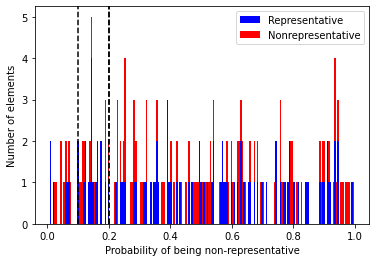

In [5]:
probs = np.random.uniform(0, 1, (2,100))
#probs = probs / sum(sum(probs))
chosen_samples = np.array(((0.1), (0.2), (0.2)))
stacked_histograms(probs[0], probs[1], chosen_samples, '', 0)

# MRS Algorithm

To allow statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [11]:
def grid_search_svm(X_train, y_train, cv = 5):
    mu, sigma = 0.01, 0.1 # mean and standard deviation
    param_grid = {'C': [abs(np.random.normal(mu, sigma, 2)), 0.5, 0.7, 2^0 ,2^1, 2^2, 2^3, 2^4, 2^5, 2^6,
                        2^7]}
    grid = GridSearchCV(LinearSVC(dual=False), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return CalibratedClassifierCV(grid.best_estimator_, n_jobs=-1)

In [12]:
def grid_search_tree(X_train, y_train, cv=3):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    param_grid = {'ccp_alpha': ccp_alphas}
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [13]:
def MRS(N: pd.DataFrame, 
        columns,
        R: pd.DataFrame,
        number_of_splits = 5,
        temperature: float=0.5,
        n_drop: int=1,
        cv=5):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """
    preds = []
    bootstrap_iterations = 5
    
    kf = KFold(n_splits=number_of_splits)
    for train_index, test_index in kf.split(N):
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        n = min(len(R), len(N_train))
        bootstrap_predictions = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R.sample(n=n, replace=True)], sort=True)
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            clf.fit(bootstrap[columns], bootstrap.label)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
        preds.extend(np.mean(bootstrap_predictions, axis=0))
        
    drop_ids = temperature_sample(preds, temperature, n_drop)
    return N.drop(N.index[drop_ids])

In [77]:
def MRS_with_histogram(N: pd.DataFrame, 
        R: pd.DataFrame,
        columns,
        number_of_splits = 5,
        temperature: float=0.5,
        n_drop: int=1,
        cv=5, directory='', iteration=0,
                      grid_search=None):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """ 
    preds = []
    preds_r = []
    highest_temperature = 1
    lowest_temperature = 0
    bootstrap_iterations = 5
    
    kf = KFold(n_splits=number_of_splits)
    for split_n, split_r in zip(kf.split(N), kf.split(R)):
        train_index, test_index = split_n
        train_index_r, test_index_r  = split_r
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        R_train, R_test = R.iloc[train_index_r], R.iloc[test_index_r]
        n = min(len(R), len(N_train))
        bootstrap_predictions = []
        bootstrap_predictions_r = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R_train.sample(n=n, replace=True)], sort=True)
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            clf.fit(bootstrap[columns], bootstrap.label)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
            bootstrap_predictions_r.append(clf.predict_proba(R_test[columns])[:,1])
        preds.extend(np.mean(bootstrap_predictions, axis=0))
        preds_r.extend(np.mean(bootstrap_predictions_r, axis=0))
        
    drop_ids = temperature_sample(preds, temperature, n_drop)
    
    q, _ = np.histogram(preds, bins=50, range=(0, 1), density=True)
    p, _ = np.histogram(preds_r, bins=50, range=(0, 1), density=True)   
    
    epsilon = 0.00001
    p = p + epsilon
    q = q + epsilon
    
    kl_value = entropy(p, q)
    kl_switched_value = entropy(q, p)
    js_value = jensenshannon(p, q, base=2)
    
    temperature = highest_temperature - js_value * (highest_temperature - lowest_temperature)
    
    if iteration % 10 == 0:
        stacked_histograms(preds_r, preds, np.array(preds)[drop_ids], directory, iteration, True, temperature)
    return N.drop(N.index[drop_ids]), kl_value, kl_switched_value, js_value

In [15]:
def repeated_MRS(df, columns, temperature, number_of_splits, number_of_iterations,
                 n_drop=1,test_size=0.33, cv=5, us=False, directory='', us_bias='',
                 grid_search=grid_search_svm):

    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    interpolation_points = 250
    median_fpr = np.linspace(0, 1, interpolation_points)
    auc = []
    roc = []
    ratio = []
    c_values = []
    kl_values = []
    kl_switched_values = []
    js_values = []
    
    
    if us:
        representative_ratio = (len(R[R[us_bias] == 1]) /
                                len(R[R[us_bias] == 0]))
    #start value
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[columns])[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    roc.append((median_fpr, interp_tpr, [0]*interpolation_points))
    auc.append(roc_auc_score(y_test, y_predict))
    
 
    for i in tqdm(range(number_of_iterations)):
        N, kl_value, kl_switched_value, js_value = MRS_with_histogram(N, R, columns,
                                number_of_splits=number_of_splits, temperature=temperature, 
                               n_drop=n_drop, cv=cv, directory=directory, iteration=i, grid_search=grid_search)
        
        kl_values.append(kl_value)
        kl_switched_values.append(kl_switched_value)
        js_values.append(js_value)
    
        data = pd.concat([N, R])
        X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf = grid_search(X_train, y_train, cv)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[columns])[:,1]
        auc.append(roc_auc_score(y_test, y_predict))
        
        
        
        # calculate auroc
        if((i+1) % 150 == 0):
            fpr, tpr, thresholds = roc_curve(y_test, y_predict)
            interp_tpr = np.interp(median_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            roc.append((median_fpr, interp_tpr, [(i+1)*drop]*interpolation_points))

       # c_values.append(clf.get_params()['base_estimator__C'])
        
        # only for US Census experiment
        if us:
            ratio.extend([len(N[N[us_bias] == 1]) / 
                         (len(N[N[us_bias] == 0]))]*drop)
            if ((i+1) % 10 == 0):
                plot_class_ratio(ratio, representative_ratio, directory + '/tmp_ratio', save=False)
                 
        if ((i+1) % 10 == 0):
            plot_probability_divergences(kl_values, kl_switched_values, js_values, 
                                         directory + '/divergence', True)
           # plot_c(c_values, directory + '/c_values', True)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
            
    if us:
        return ratio, representative_ratio, auc, roc
    else:
        return N, auc, roc

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [34]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above_Below 50K']

train = pd.read_csv(os.path.join(path, 'data/Census_Income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/Census_Income/adult.test'), names=columns)
test = test.iloc[1:]

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', 1, inplace=True)
df.replace(' >50K', 1, inplace=True)
df.replace(' <=50K.', 0, inplace=True)
df.replace(' <=50K', 0, inplace=True)

df['Sex'].replace(' Male', 0, inplace=True)
df['Sex'].replace(' Female', 1, inplace=True)

us_bias = 'Above_Below 50K'
#us_bias = 'Education'
#positive_elements_bias = [' Bachelors', ' Masters', ' Doctorate']
#df[us_bias].mask(~df[us_bias].isin(positive_elements_bias), 0, inplace=True)
#df[us_bias].mask(df[us_bias].isin(positive_elements_bias), 1, inplace=True)

df = df.replace(' ?',np.NaN)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = [
    'Workclass', 
       'Education', 
       'Marital Status',       
       'Occupation',
       'Relationship', 
       'Race', 
       'Country'
      ]
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    34014 ;; >50K     11208'''

#df_high = df[df['Above/Below 50K'] == ">50K"].copy(deep=True)
#df_low = df[df['Above/Below 50K'] == "<=50K"].copy(deep=True)

df_high = df[(df[us_bias] == 1)].copy(deep=True)
df_low = df[(df[us_bias] == 0)].copy(deep=True)


high_normal = len(df_high)
low_normal = len(df_low)

rep_fraction = 0.1
bias_fraction = 0.03

#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_low.head(int(low_normal * rep_fraction)), 
                 df_high.head(int(high_normal * rep_fraction))],
                ignore_index=True) 

nonrep_more_low = pd.concat([df_low.tail(int(low_normal * (rep_fraction + bias_fraction))), 
                             df_high.tail(int(high_normal * rep_fraction))],
                            ignore_index=True)
    

nonrep_more_high = pd.concat([df_low.tail(int(low_normal * rep_fraction)).copy(deep=True),
                              df_high.tail(int(high_normal * (rep_fraction + bias_fraction)))], 
                             ignore_index=True)


#-----------------Simulate representative data---------------------#
rep2 = pd.concat([df_low.tail(int(low_normal * rep_fraction)),
                 df_high.tail(int(high_normal * rep_fraction))],
                ignore_index=True) 

rep['label'] = 0
nonrep_more_low['label'] = 1
nonrep_more_high['label'] = 1
rep2['label'] = 1

print("Current setting:")

print('Rep: \n', rep[us_bias].value_counts())
print('Rep 2: \n', rep2[us_bias].value_counts())
print('Nonrep_more_high: \n', nonrep_more_high[us_bias].value_counts())
print('nonrep_more_low: \n', nonrep_more_low[us_bias].value_counts())

us_nonrep_more_low = pd.concat([rep.copy(deep=True), nonrep_more_low.copy(deep=True)])
us_nonrep_more_high = pd.concat([rep.copy(deep=True), nonrep_more_high.copy(deep=True)])
us_rep = pd.concat([rep.copy(deep=True), rep2.copy(deep=True)])

us_columns = list(us_rep.columns)
meta = ['label', 'index', 'bootstrap', us_bias]
for m in meta:
    if m in us_columns:
        us_columns.remove(m)
        
us_scaling_columns = [
    'Age', 
    'Capital Loss', 
    'Education Num', 
    'Capital Gain',
    'Hours/Week',
    'fnlgwt'
]

for dataset in [us_rep, us_nonrep_more_high, us_nonrep_more_low]:
    scale = StandardScaler()
    dataset[us_scaling_columns] = scale.fit_transform(dataset[us_scaling_columns])
    dataset.reset_index(drop=True, inplace=True)

Current setting:
Rep: 
 0    3401
1    1120
Name: Above_Below 50K, dtype: int64
Rep 2: 
 0    3401
1    1120
Name: Above_Below 50K, dtype: int64
Nonrep_more_high: 
 0    3401
1    1457
Name: Above_Below 50K, dtype: int64
nonrep_more_low: 
 0    4421
1    1120
Name: Above_Below 50K, dtype: int64


## Experiment 1 a)


### Simulate non-representative data. More low than in R

| income      | Representative (R) | Non-Representative (N) |
|-------------|--------------------|------------------------|
| low (<=50K) | 3715               | ????                   |
| high (>50K) | 1168               | ????                   |

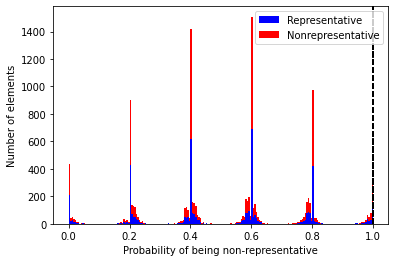

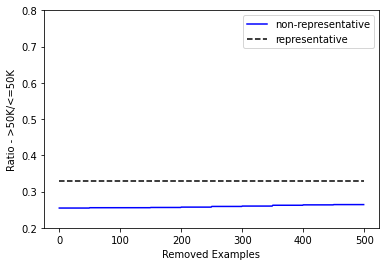

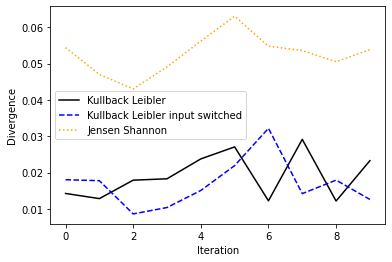

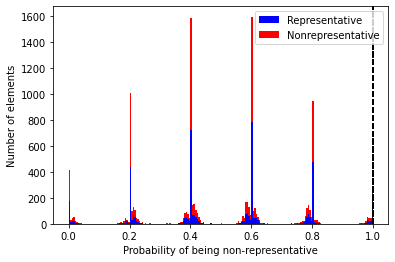

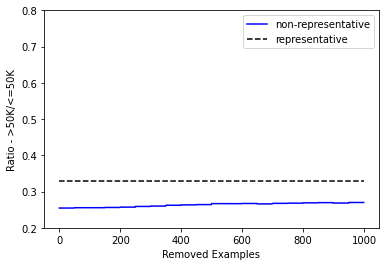

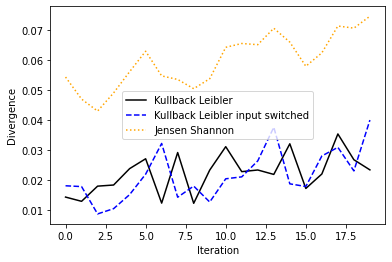

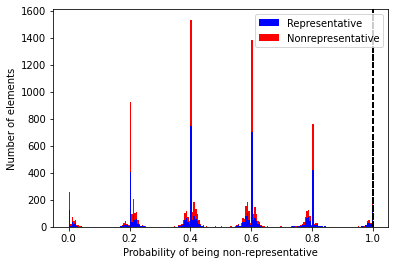

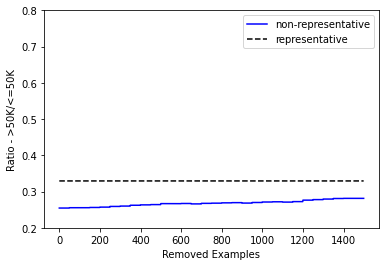

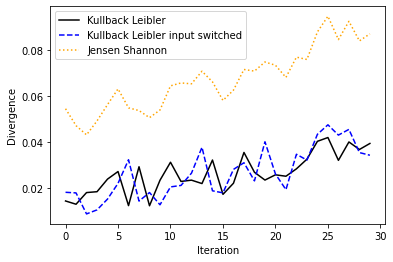

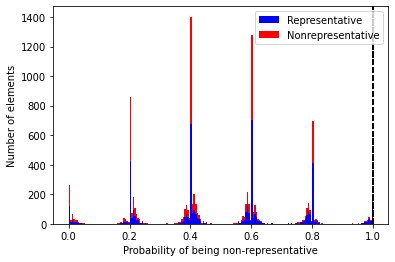

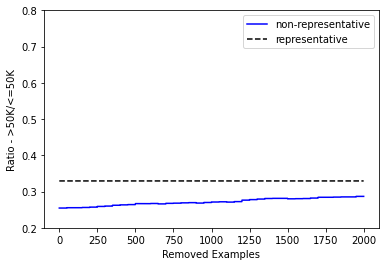

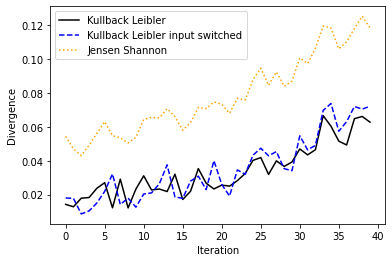

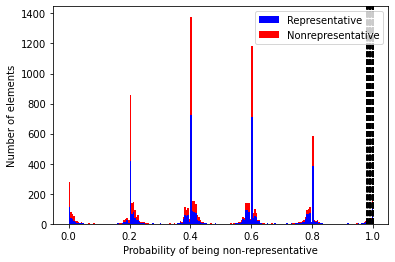

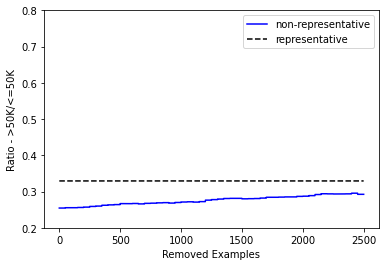

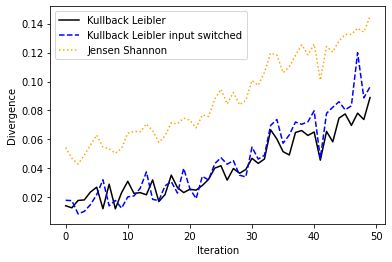

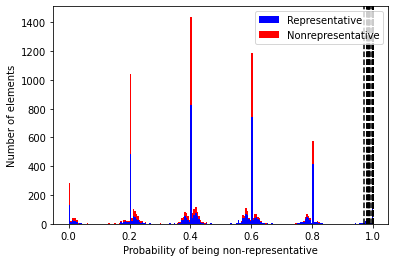

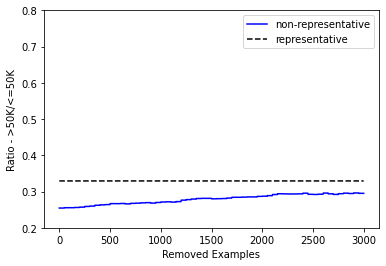

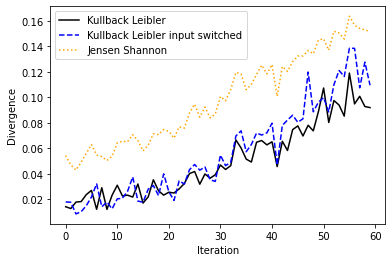

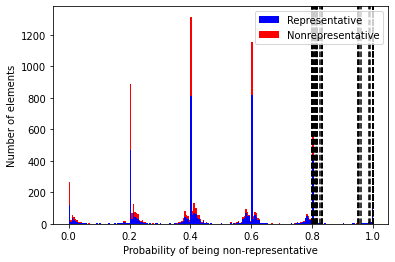

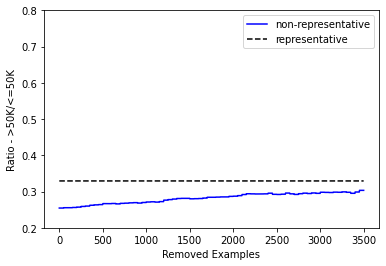

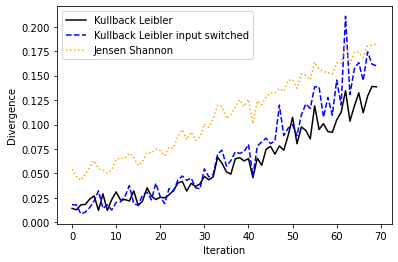

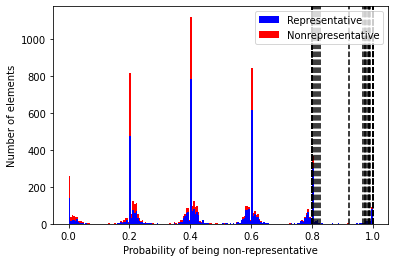

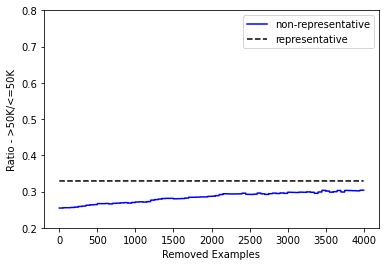

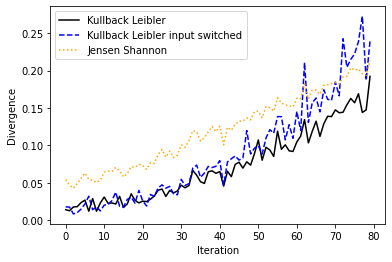

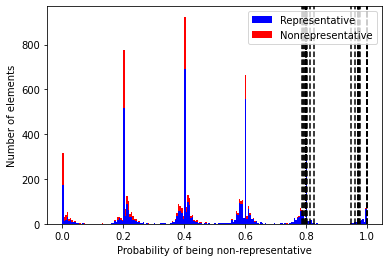

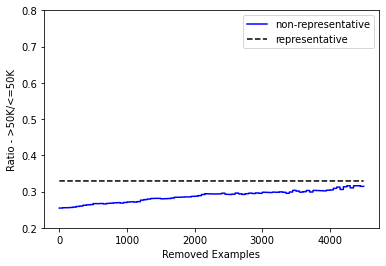

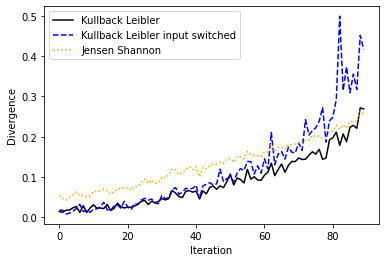

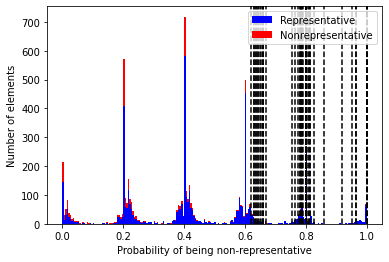

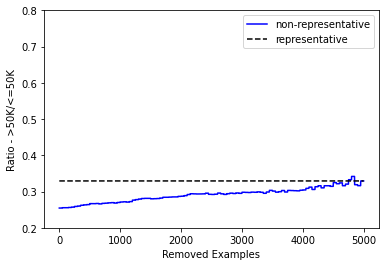

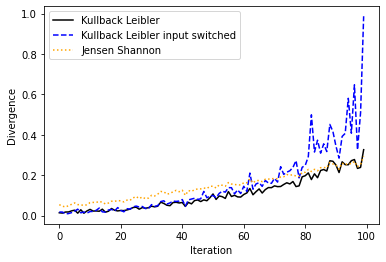

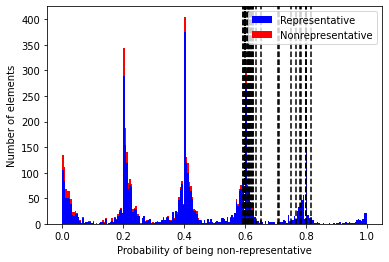

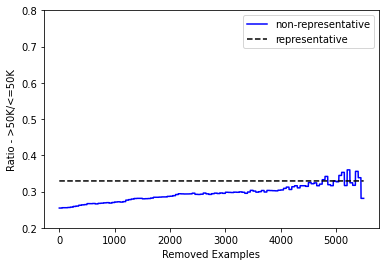

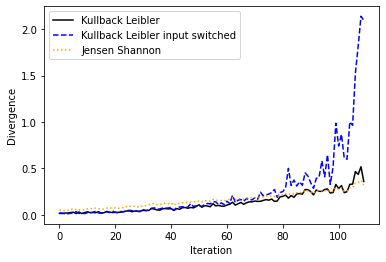

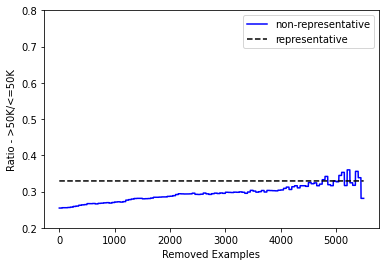

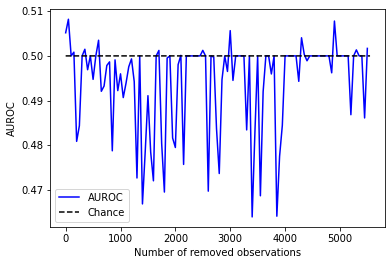

In [35]:
temperatures = [0.002]
drop = 50
number_of_splits = 5
number_of_iterations = int(len(us_nonrep_more_low[us_nonrep_more_low['label'] == 1]) / drop)
test_size = 0.33
result_dir = os.path.join(os.getcwd(), 'results/us_nonrep_more_low',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)


for temp in tqdm(temperatures):
    ratio, representative_ratio, auc, roc = repeated_MRS(us_nonrep_more_low, us_columns, temp,
                    number_of_iterations = number_of_iterations,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = 3, us = True, directory=result_dir, us_bias=us_bias,
                    grid_search=grid_search_tree)
    

    file_name = os.path.join(result_dir,  str(temp) + '_ratio_more_low' + us_bias)
    plot_class_ratio(ratio, representative_ratio, file_name, save=True)   
    plot_auc(auc, drop, file_name + '_auc', save=True)

In [ ]:
pickle.dump(ratio, open("results/ratio", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio", 'wb'))

### Load saved results

In [14]:
ratio = pickle.load(open("results/ratio", 'rb'))
representative_ratio = pickle.load(open("results/representative_ratio", 'rb'))

NameError: name 'ratio' is not defined

### Visualise results

In [ ]:
plot_class_ratio(ratio, representative_ratio, '', save=False)

## Experiment 1 b)


### Simulate non-representative data. More high than in R

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| low (<=50K) | 3715               | ????                   |
| high (>50K) | 1168               | ???                    |

*Here we run the MRS algorithm to test whether the ratio low-high is still maintained.*

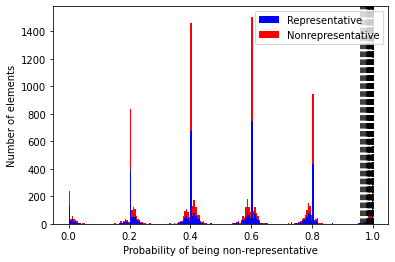

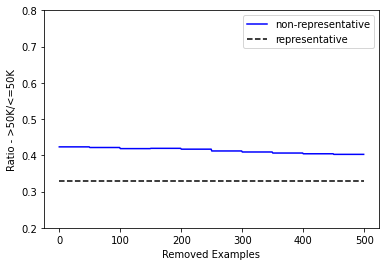

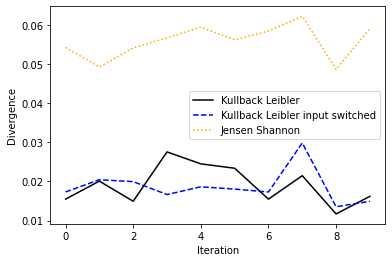

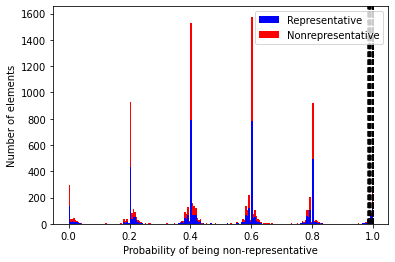

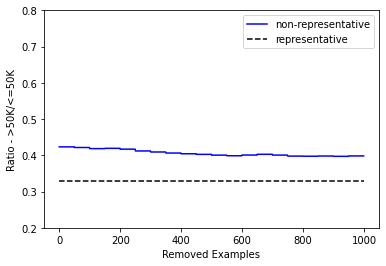

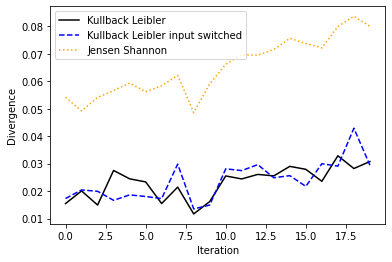

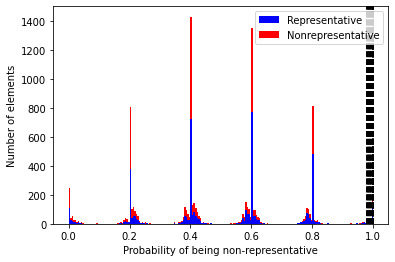

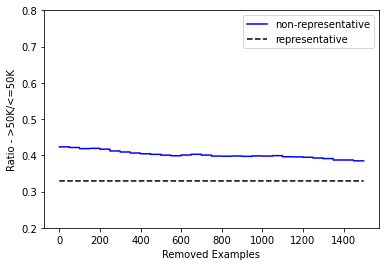

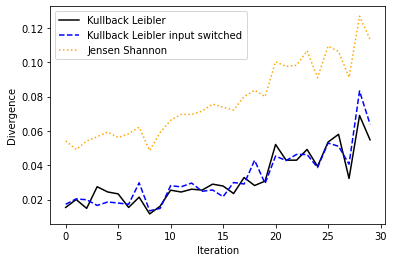

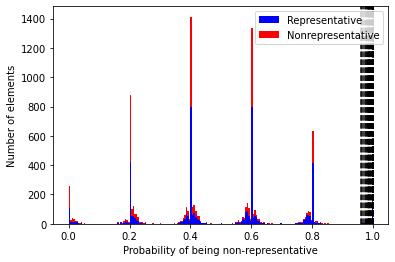

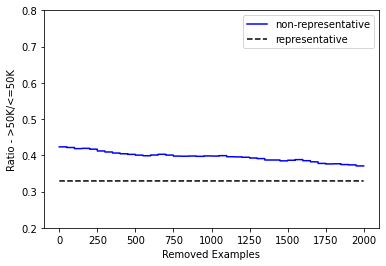

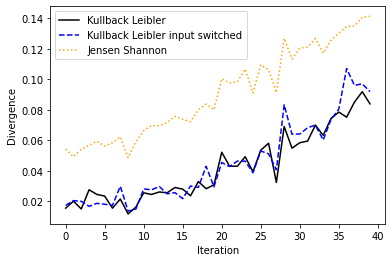

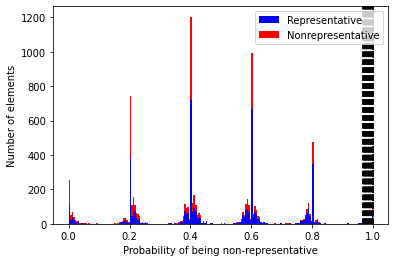

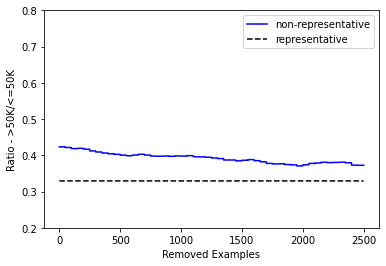

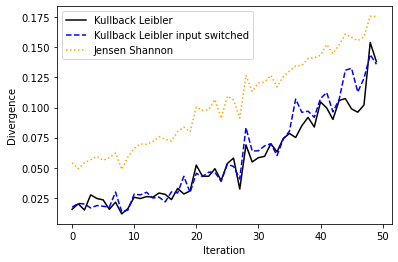

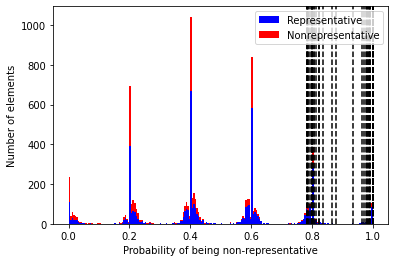

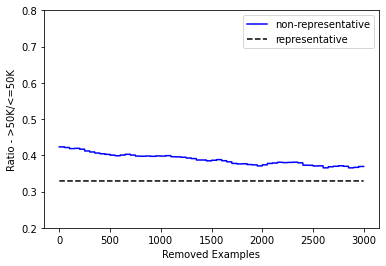

In [ ]:
temperatures = [0.02]
drop = 50
number_of_splits = 5
number_of_iterations = int(len(us_nonrep_more_high[us_nonrep_more_high['label'] == 1]) / drop)
test_size = 0.3
result_dir = os.path.join(os.getcwd(), 'results/us_nonrep_more_high',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)


for temp in tqdm(temperatures):
    ratio, representative_ratio, auc, roc = repeated_MRS(us_nonrep_more_high, us_columns, temp,
                    number_of_iterations = number_of_iterations,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = 3, us = True, directory=result_dir, us_bias=us_bias,
                                                        grid_search=grid_search_tree)
    

    file_name = os.path.join(result_dir,  str(temp)) + '_ratio_more_high' + us_bias
    plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
    plot_auc(auc, drop, file_name + '_auc', save=True)

## Experiment 1 c)


### Simulate already representative data

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| low (<=50K) | 3715               | 3715                   |
| high (>50K) | 1168               | 1168                   |

*Here we run the MRS algorithm to test whether the ratio low-high is still maintained.*

In [ ]:
temperatures = [0.002]
drop = 50
number_of_splits = 5
number_of_iterations = int(len(us_rep[us_rep['label'] == 1]) / drop)
test_size = 0.3
result_dir = os.path.join(os.getcwd(), 'results/us_rep',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)


for temp in tqdm(temperatures):
    ratio, representative_ratio, auc, roc = repeated_MRS(us_rep, us_columns, temp,
                    number_of_iterations = number_of_iterations,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = 3, us = True, directory=result_dir, us_bias=us_bias,
                                                        grid_search=grid_search_tree)
    

    file_name = os.path.join(result_dir,  str(temp)) + '_ratio_rep'  + us_bias
    plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
    plot_auc(auc, drop, file_name + '_auc', save=True)

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.PNG" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. In addition, GBS contains an attribute for positive and negative treatment of survey participents for further analysis (Experiment 4).**


## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [ ]:
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 10)

allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstaetigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']


scaler = StandardScaler()
scaled_allensbach = allensbach.copy(deep=True)
scaled_allensbach[allensbach_columns] = scaler.fit_transform(scaled_allensbach[allensbach_columns])

drop = 1
number_of_splits = 5
result_dir_allensbach = os.path.join(os.getcwd(), 'results/gbs_allensbach', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

test_size = 0.5
number_of_iterations = int((len(scaled_allensbach[scaled_allensbach['label']  == 1]) -
                           number_of_splits)/drop)

aucs = []
rocs = []

for temp in tqdm(temperatures):
    allensbach_mrs, auc, roc = repeated_MRS(scaled_allensbach, allensbach_columns, temp,
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=3, directory=result_dir_allensbach,
                                           grid_search=grid_search_tree)
    aucs.append(auc)
    rocs.append(roc)
    
    median_rocs = []
    for i in range(len(rocs[0])):
        median_tpr = np.median(np.array(rocs)[:, i, 0], axis = 0)
        median_fpr = np.median(np.array(rocs)[:, i, 1], axis = 0)
        std_tpr = np.std(np.array(rocs)[:, i, 1], axis = 0)
        removed_samples = np.array(rocs)[:, i, 2][0][0]
        median_rocs.append([median_tpr, median_fpr, std_tpr, removed_samples])
    
    
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False)
    plot_rocs(median_rocs, '', save=False)
    
plot_auc_median(median_aucs, std_aucs, drop, result_dir_allensbach + "/mediac_aucs" , save=True)
plot_rocs(median_rocs, result_dir_allensbach + "/mediac_rocs", save=True)
    
pickle.dump(median_aucs, open(result_dir_allensbach + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_allensbach + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_allensbach + "/median_rocs", 'wb'))

In [ ]:
pickle.dump(median_aucs, open("results/allensbach_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allensbach_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/allensbach_median_rocs", 'wb'))

### Load saved results

In [112]:
allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))
allensbach_rocs = pickle.load(open("results/allensbach_median_rocs", "rb"))

### Visualise results

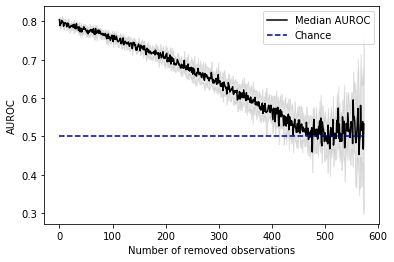

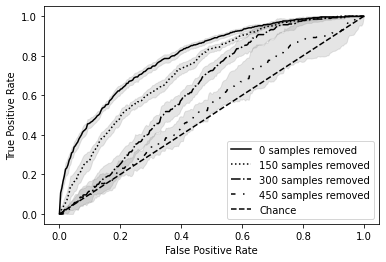

In [114]:
file_name = result_dir_allensbach + '/auc'
plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, drop, file_name, save=True)

file_name = result_dir_allensbach + '/roc'
plot_rocs(allensbach_rocs, file_name, save=True)

### Experiment 2 b)
### <font color='darkgreen'>Gesis</font>  <a name="us"></a>

In [74]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

    
'''Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wahlabsicht', 'Desinteresse Politiker', 'Zufriedenheit Leben', 'Aktiv',
       'Verärgert', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Druck', 'Optimismus Zukunft',
       'Zufriedenheit Wahlergebnis', 'Resilienz'''

N = gbs.copy()
R = gesis.copy()

N['label'] = 1
R['label'] = 0

gesis_gbs = pd.concat([N, R], ignore_index=True)

In [75]:
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

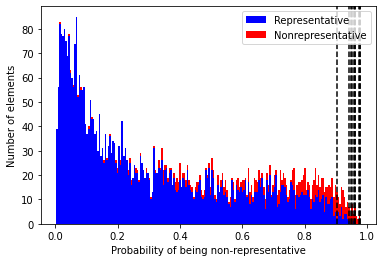

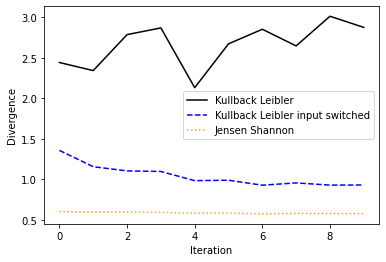

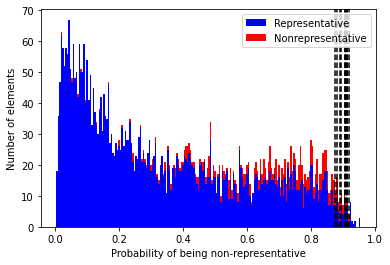

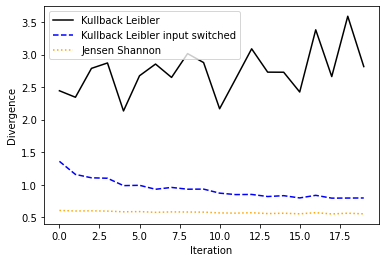

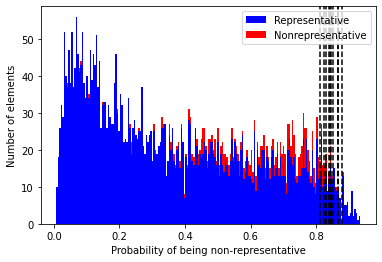

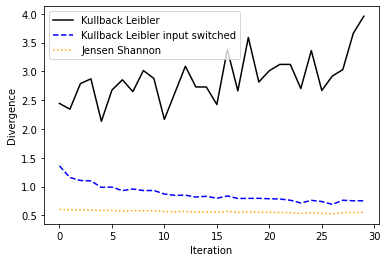

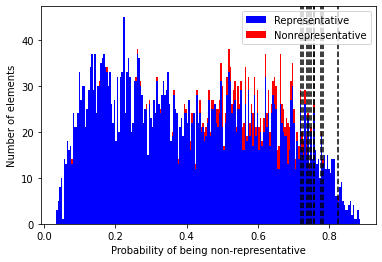

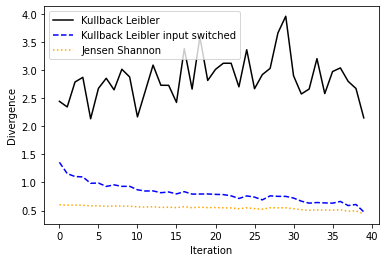

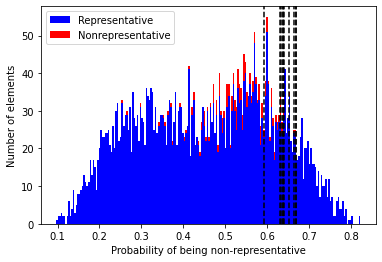

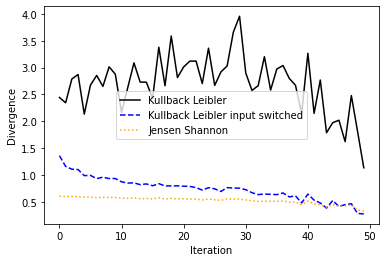

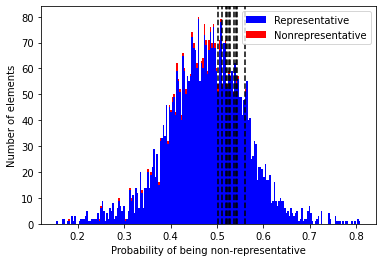

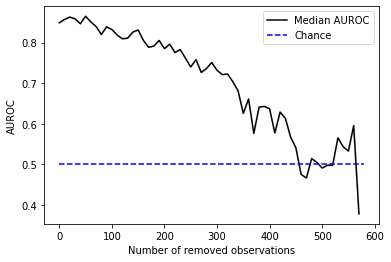

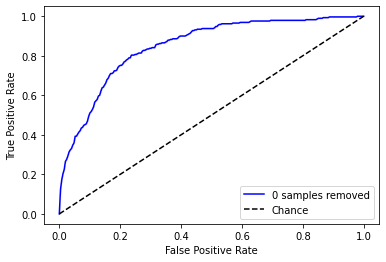

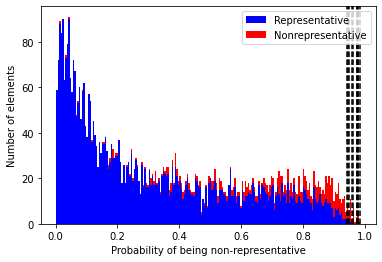

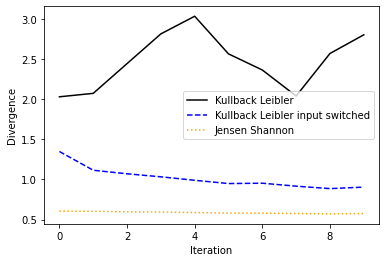

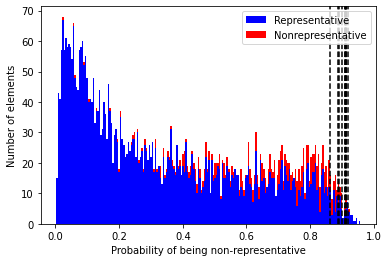

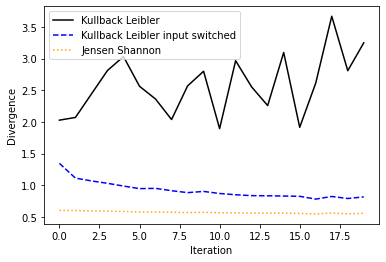

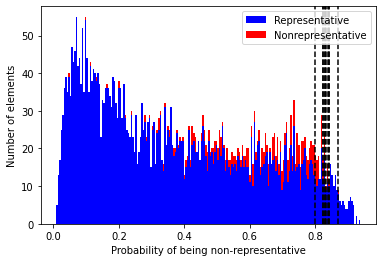

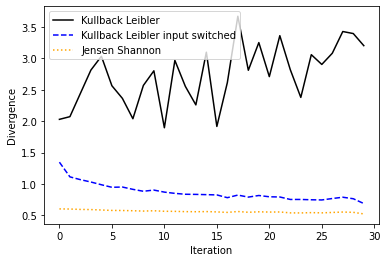

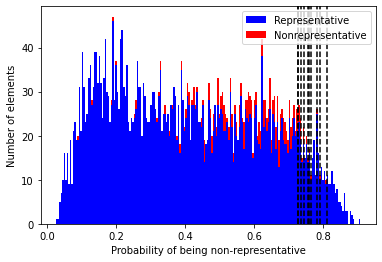

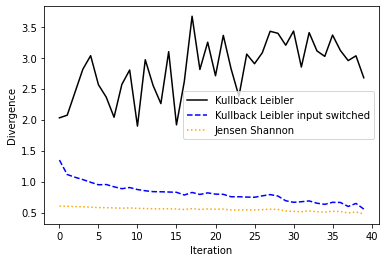

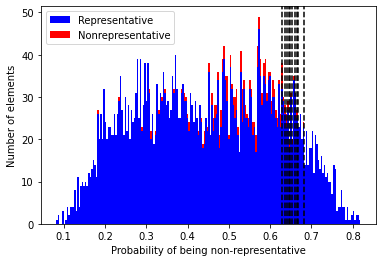

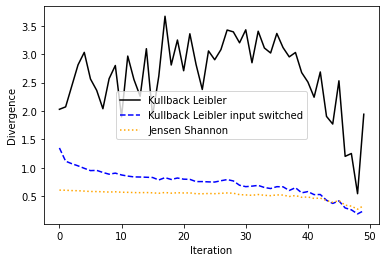

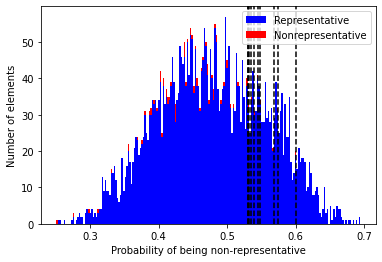

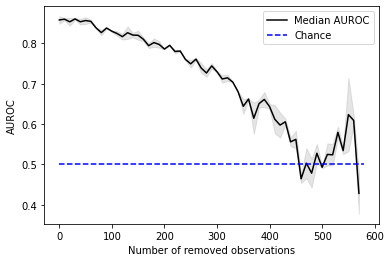

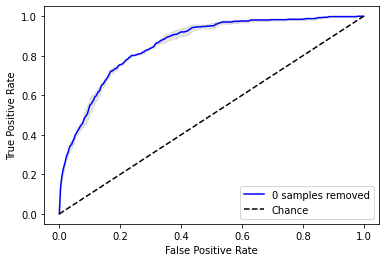

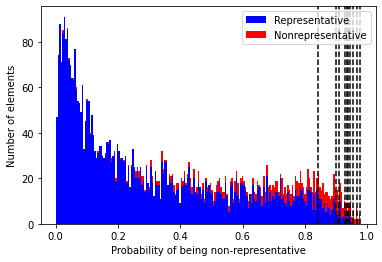

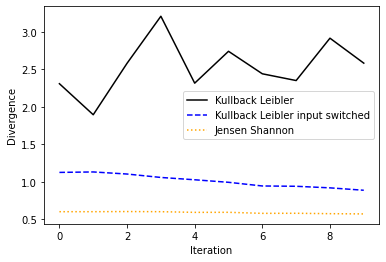

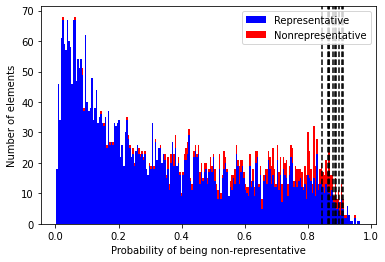

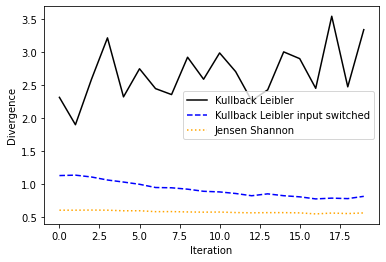

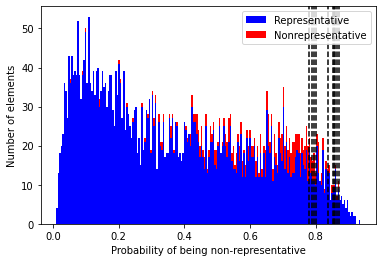

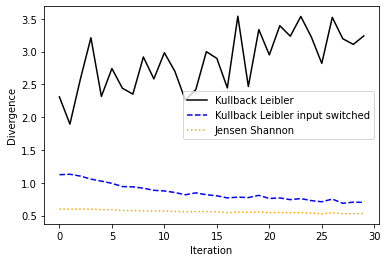

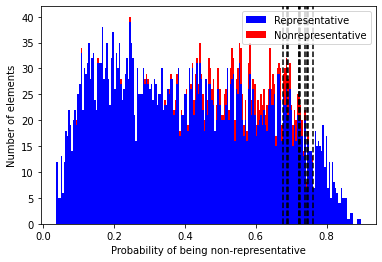

In [ ]:
mu, sigma = 0.01, 0.01
temperatures = np.random.normal(mu, sigma, 10)

drop = 10
number_of_splits = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/gbs_gesis',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.5
number_of_iterations = int((len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) -
                           number_of_splits)/drop)

os.makedirs(result_dir_gesis, exist_ok=True)
aucs = []
rocs = []

#temperatures = [0.1]
for temp in tqdm(temperatures):
    gbs_mrs, auc, roc = repeated_MRS(scaled_gesis_gbs, gesis_columns, temp,
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=5, directory=result_dir_gesis,
                                    grid_search=grid_search_svm)
    aucs.append(auc)
    rocs.append(roc)
    
    median_rocs = []
    for i in range(len(rocs[0])):
        median_tpr = np.median(np.array(rocs)[:, i, 0], axis = 0)
        median_fpr = np.median(np.array(rocs)[:, i, 1], axis = 0)
        std_tpr = np.std(np.array(rocs)[:, i, 1], axis = 0)
        removed_samples = np.array(rocs)[:, i, 2][0][0]
        median_rocs.append([median_tpr, median_fpr, std_tpr, removed_samples])
    
    
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False)
    plot_rocs(median_rocs, '', save=False)

plot_auc_median(median_aucs, std_aucs, drop, result_dir_gesis + "/mediac_aucs" , save=True)
plot_rocs(median_rocs, result_dir_gesis + "/mediac_rocs", save=True)

pickle.dump(median_aucs, open(result_dir_gesis + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_gesis + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_gesis + "/median_rocs", 'wb'))

In [107]:
pickle.dump(median_aucs, open("results/gesis_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/gesis_median_rocs", 'wb'))

NameError: name 'median_rocs' is not defined

### Load saved results

In [51]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_rocs =  pickle.load(open("results/gesis_median_rocs", 'rb'))

### Visualise results

In [55]:
file_name = result_dir_gesis + '/auc'
plot_auc_median(gesis_median_aucs, gesis_std_aucs, drop, file_name, save=False)

file_name = result_dir_gesis + '/roc'
plot_rocs(gesis_median_rocs, file_name, save=False)

NameError: name 'gesis_median_aucs' is not defined

### Experiment 2 c)
### <font color='darkgreen'> Comparison with a third independent dataset (Allensbach) </font>

In [318]:
def repeated_MRS_with_third_dataset(df, columns, temperature, comparing_dataset, comparing_dataset_columns,
                                    number_of_splits, number_of_iterations,
                                    n_drop=1, test_size=0.33, cv=5):

    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    C = comparing_dataset.copy()
    auc = []
    comparison_auc = []

    #start value
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[columns])[:,1]
    auc.append(roc_auc_score(y_test, y_predict))
    
    # start value checking
    data = pd.concat([N, C])
    X_train, X_test, y_train, y_test = train_test_split(data[comparing_dataset_columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[comparing_dataset_columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[comparing_dataset_columns])[:,1]
    comparison_auc.append(roc_auc_score(y_test, y_predict))
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS(N, R, columns, number_of_splits=number_of_splits, temperature=temperature, n_drop=n_drop, cv=cv)
        
        # auc gesis
        data = pd.concat([N, R])
        X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[columns])[:,1]
        auc.append(roc_auc_score(y_test, y_predict))
        
        # auc allensbach
        data = pd.concat([N, C])
        X_train, X_test, y_train, y_test = train_test_split(data[comparing_dataset_columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf = grid_search(X_train[comparing_dataset_columns], y_train, cv)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[comparing_dataset_columns])[:,1]
        comparison_auc.append(roc_auc_score(y_test, y_predict))
           
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    return N, auc, comparison_auc

In [22]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung',  
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

gbs_scaling_columns = ['Geburtsjahr', 'Geburtsland', 'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Personen im Haushalt', 'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Alter', 'Geschlecht', 'BRS1', 'BRS2', 'BRS3',
                      'BRS4', 'BRS5', 'BRS6','woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus', 'Schulabschluss']


all_columns = ['Erwerbstaetigkeit', 'Geschlecht']

allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']
           

gbs['label'] = 1
gesis['label'] = 0
gesis_gbs = pd.concat([gbs, gesis])

In [328]:
# calculate with allensbach
scaled_allensbach_gbs = allensbach.copy(deep=True)
scaled_gesis_checking = gesis.copy(deep=True)

all_scaler = StandardScaler()
all_scaler = all_scaler.fit(pd.concat([scaled_allensbach_gbs[all_columns], scaled_gesis_checking[all_columns]]))


scaler_allensbach = StandardScaler()
scaled_allensbach_gbs[allensbach_columns] = scaler_allensbach.fit_transform(scaled_allensbach_gbs[allensbach_columns])
scaled_allensbach_gbs[all_columns] = all_scaler.transform(scaled_allensbach_gbs[all_columns])
scaled_gesis_checking[all_columns] = all_scaler.transform(scaled_gesis_checking[all_columns])


# calculate with gesis
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_allensbach_checking = allensbach[allensbach['label']==0].copy(deep=True)

all_scaler = StandardScaler()
scaler_gesis = StandardScaler()
all_scaler = all_scaler.fit(pd.concat([scaled_gesis_gbs[all_columns], scaled_allensbach_checking[all_columns]]))
scaled_gesis_gbs[all_columns] = all_scaler.transform(scaled_gesis_gbs[all_columns])
scaled_gesis_gbs[gesis_columns] = scaler_gesis.fit_transform(scaled_gesis_gbs[gesis_columns])

scaled_allensbach_checking[all_columns] = all_scaler.transform(scaled_allensbach_checking[all_columns])

In [338]:
gesis.Erwerbstaetigkeit.unique()

array([2., 1., 3.])

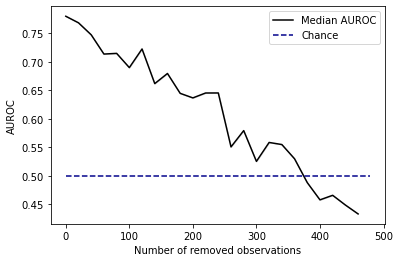

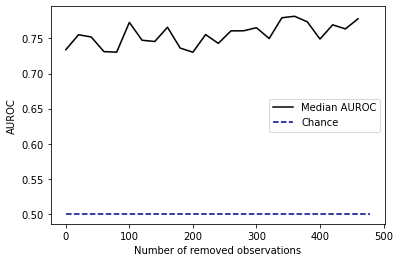

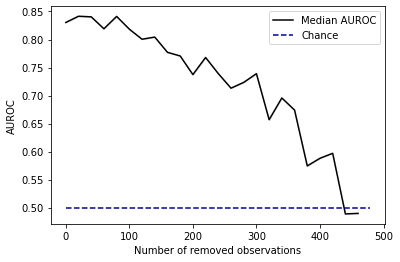

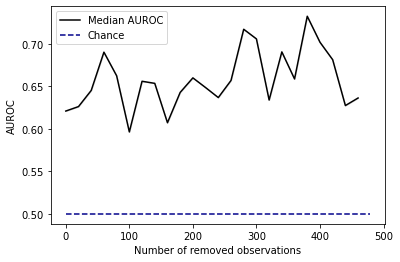

In [332]:
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 1)

drop = 20
number_of_splits = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_gesis_allensbach_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
result_dir_allensbach = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_allensbach_gesis_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))


cv = 5
test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) / drop - number_of_splits)

aucs_gesis = []
aucs_gesis_checking = []
aucs_allensbach = []
aucs_allensbach_checking = []


#calculate mrs with allensbach
for temp in tqdm(temperatures):
    _, auc_allensbach, auc_gesis_checking = repeated_MRS_with_third_dataset(scaled_allensbach_gbs, 
                      allensbach_columns, temp, comparing_dataset=scaled_gesis_checking, 
                      comparing_dataset_columns=all_columns, 
                      number_of_iterations=number_of_iterations, 
                      number_of_splits=number_of_splits, n_drop=drop, test_size=test_size, cv=cv)
    
    
    # allensbach
    aucs_allensbach.append(auc_allensbach)
    allensbach_median_aucs = np.median(aucs_allensbach, axis = 0)
    allensbach_std_aucs = np.std(aucs_allensbach, axis = 0)
    plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, drop, '', save=False)
    
    # gesis checking
    aucs_gesis_checking.append(auc_gesis_checking)
    gesis_median_comparison_aucs = np.median(aucs_gesis_checking, axis = 0)
    gesis_std_comparison_aucs = np.std(aucs_gesis_checking, axis = 0)
    plot_auc_median(gesis_median_comparison_aucs, gesis_std_comparison_aucs, drop, '', save=False)
    
# calculate mrs with gesis
for temp in tqdm(temperatures):
    _, auc_gesis, auc_allensbach_checking = repeated_MRS_with_third_dataset(scaled_gesis_gbs, gesis_columns, temp,
                            comparing_dataset=scaled_allensbach_checking, 
                            comparing_dataset_columns=all_columns,
                            number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                            n_drop=drop, test_size=test_size, cv=cv)
    
    # gesis
    aucs_gesis.append(auc_gesis)
    gesis_median_aucs = np.median(aucs_gesis, axis = 0)
    gesis_std_aucs = np.std(aucs_gesis, axis = 0)
    plot_auc_median(gesis_median_aucs, gesis_std_aucs, drop, '', save=False) 
    
    # allensbach checking
    aucs_allensbach_checking.append(auc_allensbach_checking)
    allensbach_median_comparison_aucs = np.median(aucs_allensbach_checking, axis = 0)
    allenbach_std_comparison_aucs = np.std(aucs_allensbach_checking, axis = 0)
    plot_auc_median(allensbach_median_comparison_aucs, allenbach_std_comparison_aucs, drop, '', save=False)
     
os.makedirs(result_dir_gesis, exist_ok=True)
os.makedirs(result_dir_allensbach, exist_ok=True)

pickle.dump(allensbach_median_aucs, open(result_dir + "/allensbach_median_aucs", 'wb'))
pickle.dump(allensbach_std_aucs, open(result_dir + "/allensbach_std_aucs", 'wb'))
pickle.dump(allensbach_median_comparison_aucs, open(result_dir + "/allensbach_median_comparison_aucs", 'wb'))
pickle.dump(allenbach_std_comparison_aucs, open(result_dir + "/allenbach_std_comparison_aucs", 'wb'))

pickle.dump(gesis_median_aucs, open(result_dir + "/gesis_median_aucs", 'wb'))
pickle.dump(gesis_std_aucs, open(result_dir + "/gesis_std_aucs", 'wb'))
pickle.dump(gesis_median_comparison_aucs, open(result_dir + "/gesis_median_comparison_aucs", 'wb'))
pickle.dump(gesis_std_comparison_aucs, open(result_dir + "/gesis_std_comparison_aucs", 'wb'))

In [35]:
pickle.dump(allensbach_median_comparison_aucs, open("results/allensbach_median_comparison_aucs", 'wb'))
pickle.dump(allenbach_std_comparison_aucs, open("results/allenbach_std_comparison_aucs", 'wb'))

pickle.dump(gesis_median_comparison_aucs, open("results/gesis_median_comparison_aucs", 'wb'))
pickle.dump(gesis_std_comparison_aucs, open("results/gesis_std_comparison_aucs", 'wb'))

### Load saved results

In [99]:
allensbach_median_comparison_aucs = pickle.load(open("results/allensbach_median_comparison_aucs", 'rb'))
allenbach_std_comparison_aucs = pickle.load(open("results/allenbach_std_comparison_aucs", 'rb'))

gesis_median_comparison_aucs = pickle.load(open("results/gesis_median_comparison_aucs", 'rb'))
gesis_std_comparison_aucs = pickle.load(open("results/gesis_std_comparison_aucs", 'rb'))

allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))

gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))

### Visualise results

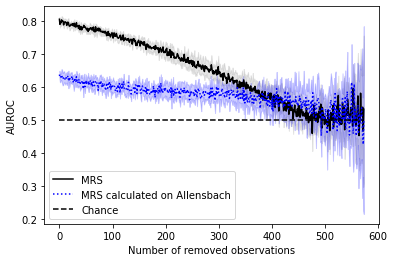

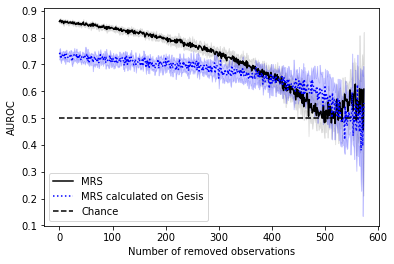

In [101]:
experiment_label = 'MRS calculated on Allensbach'
file_name = result_dir_allensbach + '/calculated_allensbach'
plot_experiment_comparison(allensbach_median_aucs, allensbach_std_aucs, gesis_median_comparison_aucs,
                      gesis_std_comparison_aucs, experiment_label, drop, file_name, save=True)

experiment_label = 'MRS calculated on Gesis'
file_name = result_dir_gesis + '/calculated_gesis'
plot_experiment_comparison(gesis_median_aucs, gesis_std_aucs, allensbach_median_comparison_aucs, 
                      allenbach_std_comparison_aucs, experiment_label, drop, file_name, save=True)

# Compare MRS with temperature sampling and without 

### Run experiment

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

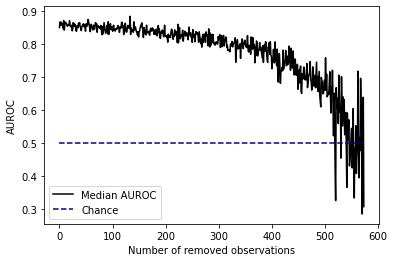

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


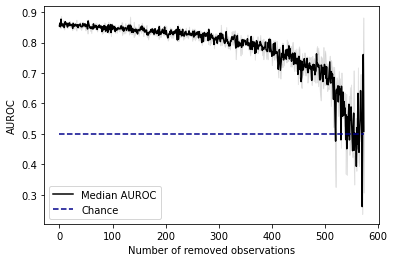

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

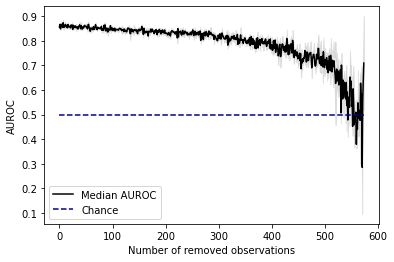

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


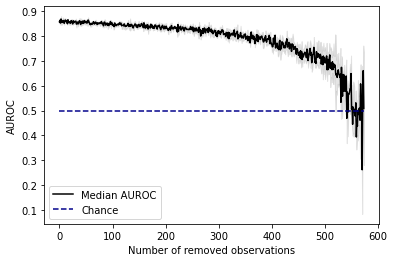

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


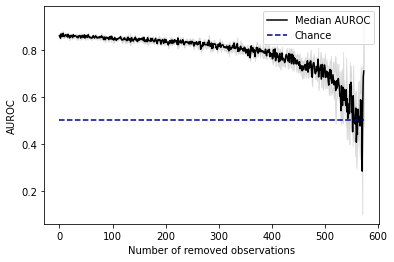

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

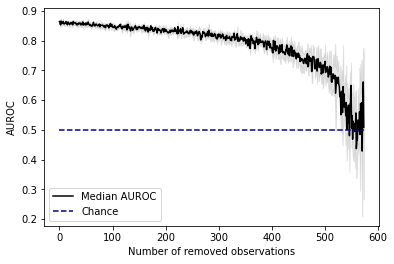

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


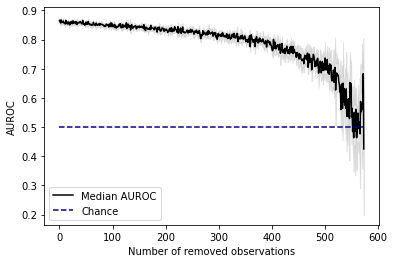

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

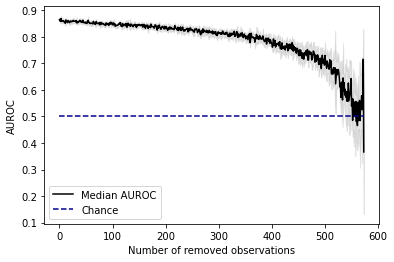

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

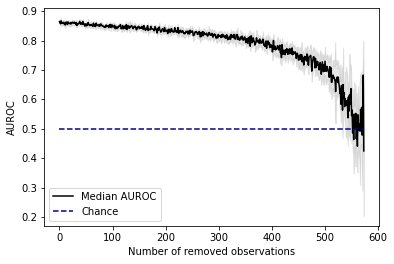

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


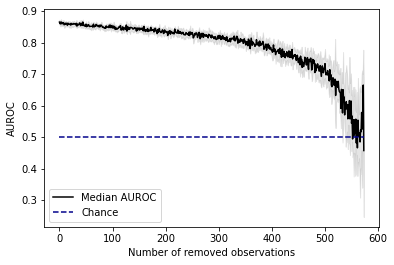

In [13]:
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 10)
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_scaling_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_scaling_columns])

drop = 1
number_of_splits = 5
result_dir_temperature = os.path.join(os.getcwd(), 'results/temperature_comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))


test_size = 0.5
number_of_iterations = int((len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) -
                           number_of_splits)/drop)
#number_of_iterations = 50

aucs_without_temperature = [] 
    
for _ in tqdm(range(10)):
    _, auc_without_temperature, _ = repeated_MRS(scaled_gesis_gbs, gesis_columns, 1, 
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=3, result_directory=result_dir_temperature)
    
    aucs_without_temperature.append(auc_without_temperature)
    median_aucs_without_temperature = np.median(aucs_without_temperature, axis = 0)
    std_aucs_without_temperature = np.std(aucs_without_temperature, axis = 0)
    plot_auc_median(median_aucs_without_temperature, std_aucs_without_temperature, drop, '', save=False)
    
os.makedirs(result_dir_temperature, exist_ok=True)
pickle.dump(median_aucs_without_temperature, open(result_dir_temperature + "/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs_without_temperature, open(result_dir_temperature + "/std_aucs_without_temperature", 'wb'))

In [ ]:
pickle.dump(median_aucs_without_temperature, open("results/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs_without_temperature, open("results/std_aucs_without_temperature", 'wb'))

### Load saved results

In [97]:
median_aucs_without_temperature = pickle.load(open("results/median_aucs_without_temperature", 'rb'))
std_aucs_without_temperature = pickle.load(open("results/std_aucs_without_temperature", 'rb'))

median_aucs_temperature = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_temperature = pickle.load(open("results/gesis_std_aucs", 'rb'))

### Visualise results

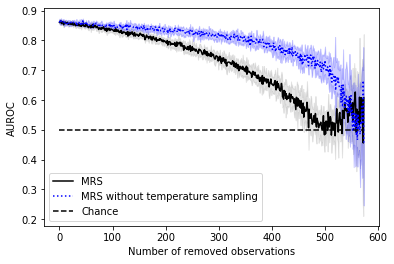

In [98]:
experiment_label = 'MRS without temperature sampling'   
file_name = result_dir_temperature + '/temperature_comparison'
plot_experiment_comparison(median_aucs_temperature, std_aucs_temperature, median_aucs_without_temperature, 
                                std_aucs_without_temperature, experiment_label, 
                           drop, file_name, save=True)   

# Compare MRS with cross-validation and without

In [8]:
def MRS_without_cv(N: pd.DataFrame, R: pd.DataFrame, columns: list, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5):
    
    preds = []
    bootstrap_iterations = 20
    kf = KFold(n_splits=number_of_splits)
    bootstrap_predictions = np.zeros(len(N))
    counter = np.zeros(len(N))
    n = min(len(R), len(N))
    for _ in range(bootstrap_iterations):
        n_sample = N.sample(n=n, replace=True)
        N_test = N.drop(n_sample.index)
        
        while len(N_test) == 1:
            n_sample = N.sample(n=n, replace=True)
            N_test = N.drop(n_sample.index)
        
        bootstrap = pd.concat([n_sample,
                                  R.sample(n=n, replace=True)])
        
        locations_not_in_bootstrap = list(set([N.index.get_loc(index) for index in N_test.index]))
        clf = grid_search(bootstrap[columns], bootstrap.label, 5)
        clf.fit(bootstrap[columns], bootstrap.label)
        proba = clf.predict_proba(N_test[columns])[:,1]
        bootstrap_single = np.zeros(len(N))
        bootstrap_single[list(locations_not_in_bootstrap)] = proba
        counter[list(locations_not_in_bootstrap)] += 1
        bootstrap_predictions += bootstrap_single
    with np.errstate(divide='ignore'):
        preds = bootstrap_predictions / counter
    preds = [0 if x != x else x for x in preds]
    drop_ids = temperature_sample(preds, 1, n_drop)
    return N.drop(N.index[drop_ids])

def repeated_MRS_without_cv(df, columns, temperature, number_of_splits, number_of_iterations,
                 n_drop=1,test_size=0.33, cv=5, us=False):

    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    auc = []
    
    #start value
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[columns])[:,1]
    auc.append(roc_auc_score(y_test, y_predict))
    
 
    for i in tqdm(range(number_of_iterations)):
        N = MRS_without_cv(N, R, columns, number_of_splits=number_of_splits, temperature=temperature, n_drop=n_drop, cv=cv)
        
        data = pd.concat([N, R])
        X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[columns])[:,1]
        auc.append(roc_auc_score(y_test, y_predict))

        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break  

    return auc 

In [ ]:
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 10)
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_scaling_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_scaling_columns])

drop = 1
number_of_splits = 5
result_dir_cv = os.path.join(os.getcwd(), 'results/cv__comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.5
number_of_iterations = int((len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) -
                           number_of_splits)/drop)
#number_of_iterations = 50

aucs_with_cv = []
aucs_without_cv = [] 
    
for temp in tqdm(temperatures):
    auc_without_cv = repeated_MRS_without_cv(scaled_gesis_gbs, gesis_columns, temp, 
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=3)
    
    aucs_without_cv.append(auc_without_cv)
    median_aucs_without_cv = np.median(aucs_without_cv, axis = 0)
    std_aucs_without_cv = np.std(aucs_without_cv, axis = 0)
    plot_auc_median(median_aucs_without_cv, std_aucs_without_cv, drop, '', save=False)
    
plot_auc_cv_comparison(median_aucs_cv, std_aucs_cv, median_aucs_without_cv, 
                                std_aucs_without_cv, drop, '', save=False)   
os.makedirs(result_dir_cv, exist_ok=True)
pickle.dump(median_aucs_without_cv, open(result_dir_cv + "/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs_without_cv, open(result_dir_cv + "/std_aucs_without_cv", 'wb'))

In [ ]:
pickle.dump(median_aucs_without_cv, open("results/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs_without_cv, open("results/std_aucs_without_cv", 'wb'))

### Load saved results

In [45]:
median_aucs_cv = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_cv = pickle.load(open("results/gesis_std_aucs", 'rb'))

median_aucs_without_cv = pickle.load(open("results/median_aucs_without_cv", 'rb'))
std_aucs_without_cv = pickle.load(open("results/std_aucs_without_cv", 'rb'))

### Visualise results

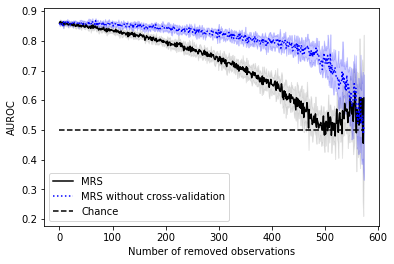

In [95]:
experiment_label = 'MRS without cross-validation'
file_name = result_dir_cv + '/cross_validation_comparison'
 
plot_experiment_comparison(median_aucs_cv, std_aucs_cv, median_aucs_without_cv, 
                                std_aucs_without_cv, experiment_label, drop, 
                           file_name, save=True)    

# Random drops

### Run experiment

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/tony/miniconda3/envs/mrs/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated clas

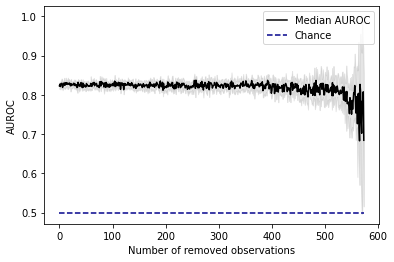

In [39]:
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

drop = 1
result_dir = os.path.join(os.getcwd(), 'results/random_drop',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

cv = 5
test_size = 0.5

aucs_random_drop = []

for _ in tqdm(range(10)):
    
    N = scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1].copy()
    R = scaled_gesis_gbs[scaled_gesis_gbs['label'] == 0].copy()
    iterations = len(N) - cv - 1
    auc = []
    #start value
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[gesis_columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[gesis_columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[gesis_columns])[:,1]
    auc.append(roc_auc_score(y_test, y_predict))
        
    for _ in tqdm(range(iterations)):
        
        random_int = random.randrange(len(N))
        N.drop(N.index[random_int], inplace=True)
    
        data = pd.concat([N, R])
        X_train, X_test, y_train, y_test = train_test_split(data[gesis_columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    
        clf = grid_search(X_train[gesis_columns], y_train, cv)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[gesis_columns])[:,1]
        auc.append(roc_auc_score(y_test, y_predict))
    aucs_random_drop.append(auc)
    
median_aucs_random_drop = np.median(aucs_random_drop, axis = 0)
std_aucs_random_drop = np.std(aucs_random_drop, axis = 0)
plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, '', save=False)

os.makedirs(result_dir, exist_ok=True)
pickle.dump(median_aucs_random_drop, open(result_dir + "/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open(result_dir + "/std_aucs_random_drop", 'wb'))

In [42]:
pickle.dump(median_aucs_random_drop, open("results/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open("results/std_aucs_random_drop", 'wb'))

### Load saved results

In [75]:
median_aucs_random_drop = pickle.load(open("results/median_aucs_random_drop", 'rb'))
std_aucs_random_drop = pickle.load(open("results/std_aucs_random_drop", 'rb'))

median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))

### Visualise results

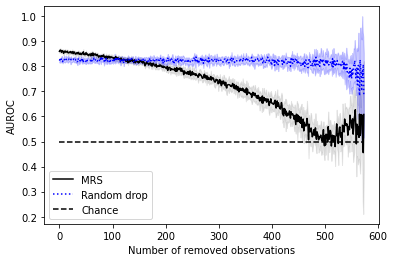

In [93]:
experiment_label = 'Random drop'
file_name = result_dir + '/random_drop_experiment'
plot_experiment_comparison(median_aucs, std_aucs, median_aucs_random_drop, 
                                std_aucs_random_drop, experiment_label, drop, file_name,  True)

# Calculate AUROC between Gesis and Allensbach

In [325]:
columns = ['Erwerbstaetigkeit', 'Geschlecht']
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_copy = allensbach.copy(deep=True)
gesis_copy = gesis.copy(deep=True) 
gesis_copy['label'] = 1
allensbach_gesis = pd.concat([allensbach_copy, gesis_copy])

scaler = StandardScaler()
scaled_allensbach_gesis = allensbach_gesis.copy(deep=True)
scaled_allensbach_gesis[columns] = scaler.fit_transform(scaled_allensbach_gesis[columns])

X_train, X_test, y_train, y_test = train_test_split(scaled_allensbach_gesis[columns], scaled_allensbach_gesis.label,
                                                         test_size=0.3, stratify=scaled_allensbach_gesis.label)
clf = grid_search(X_train[columns], y_train, 5)
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test[columns])[:,1]
print(roc_auc_score(y_test, y_predict))

0.584382822677137


## Generate MRS

In [12]:
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[scaling_columns] = scaler.fit_transform(scaled_gesis_gbs[scaling_columns])

mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 1)

drop = 1
number_of_splits = 5
result_dir = os.path.join(os.getcwd(), 'results/gbs_mrs',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.5
number_of_iterations = 500

for temp in tqdm(temperatures):
    gbs_mrs, _, _ = repeated_MRS(scaled_gesis_gbs, gesis_columns, temp,
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=5, result_directory=result_dir)

## Preprocessing GBS

**Run only if you want to recreate the data from the raw data - pocessed data is already saved**

## GBS Prediction: Participation in Elections (Wahlteilnahme)

In [37]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

gbs__ = pd.read_csv(os.path.join(path, 'data/GBS/gbs1_p.csv'), sep=" ")
gbs__.columns = ['col']

personen = []

for i in range(gbs__.shape[0]):
    person_data = str(gbs__.loc[i].values)
    if ('mehrere Personen' in person_data):
        personen.append(int (person_data.split("mehrere Personen, und zwar:\",",1)[1][0]))
    else:
        personen.append(1)
        
gbs1['am24'] = personen

df = pd.merge(gbs1, gbs2, how='inner', on=key)
df = pd.merge(df, mapping1, how='left', on=key)
df = pd.merge(df, mapping2, how='left', on=key)

attributes1 = ['am01','am02_01','am02_02', 'am11','am10','am23','am14','am15','am17','am22','am24','am29','am27']
attributes2 = ['gh03_08','gh08_03','gh04_01','gh05_01','pt04',
               'pt03_01','pt01_02','gh07_01','gh04_01','gh03_10','gh03_07','gh03_13','gh03_11']
attributes3 = ['v2673_1_bfi_bfi1','v2673_1_bfi_bfi2','v2673_1_bfi_bfi3','v2673_1_bfi_bfi4','v2673_1_bfi_bfi5',
               'v2673_1_bfi_bfi6','v2673_1_bfi_bfi7','v2673_1_bfi_bfi8','v2673_1_bfi_bfi9','v2673_1_bfi_bfi10']
attributes4 = ['gh03_09','lo01_04','pt06_01','br01_06']

attributes5 = ['br01_01', 'br01_02', 'br01_03', 'br01_04', 'br01_05', 'br01_06',
           'am20_01', 'so01_01', 'so02_01', 'am14']

attribute_name1 = ['Geschlecht','Geburtsjahr','Alter', 'Geburtsland','Nationalitaet','Familienstand','Hoechster Bildungsabschluss',
                    'Berufliche Ausbildung','Erwerbstaetigkeit','Berufsgruppe','Personen im Haushalt',
                    'Nettoeinkommen Selbst','Nettoeinkommen Haushalt']
attribute_name2 = ['Schlechter Schlaf','Leben genießen','Zu Nichts aufraffen','Alles anstrengend','Wahlteilnahme','Wahlabsicht',
                    'Desinteresse Politiker','Zufriedenheit Leben','Aktiv','Verärgert','Wach','Nervös','Ängstlich']
attribute_name3 = ['Zurueckhaltend','leicht Vertrauen','Faulheit','Entspannt','wenig kuenstlerisches Interesse','Gesellig',
                    'Andere kritisieren','Gruendlich','Nervoes','Phantasievoll']
attribute_name4 = ['Druck','Optimismus Zukunft','Zufriedenheit Wahlergebnis','Resilienz']
attribute_name5 = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6',
         'woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus', 'Schulabschluss']

df = df[[key] + ['Gruppe'] + attributes1 + attributes2 +  attributes3 + attributes4 + attributes5]
df.columns = [key] + ['Gruppe'] + attribute_name1 + attribute_name2 + attribute_name3 + attribute_name4 + attribute_name5

df = df.sort_values(by=['GBS-CODE'])

*Almost every survey participant is counted twice in the dataframe (due to previous joins). The next code snippet gets rid of duplicate entries by merging them and avering column values. They are almost (or near) identical, so this should be fine.*

In [341]:
def merge(arr1, arr2):
    result = []
    for i,j in zip(arr1, arr2):
        if(i != i):
            result.append(j)
        else:
            result.append(i)
    return result

tmp = pd.DataFrame(columns=df.columns)

j = 0
skip = False

for i in range(len(df.Gruppe)-1):
    if(not skip):
        if(df.iloc[i]["GBS-CODE"] == df.iloc[i+1]["GBS-CODE"]):
            tmp.loc[j] = merge(df.iloc[i].values, df.iloc[i+1].values)
            j = j+1
            skip = True
        else:
            tmp.loc[j] = df.iloc[i].values
            j = j+1
    else:
        skip = False
        
df = tmp.copy()
del tmp

In [ ]:
rep1 = {
    '5 Trifft voll und ganz zu':5,
    '4 Eher zutreffend':4,
    '3 Weder noch':3,
    '2 Trifft eher nicht zu':2,
    '1 Trifft überhaupt nicht zu':1,
    
    'trifft voll und ganz zu (5)':5,
    'eher zutreffend (4)':4,
    'weder noch (3)':3,     
    'trifft eher nicht zu (2)':2,
    'trifft ueberhaupt nicht zu (1)':1, 
    
    'Unit nonresponse':np.nan,
    'Not in panel':np.nan,
    'Item nonresponse':np.nan,
    'Not reached':np.nan,
    'Ambiguous answer':np.nan,
    'keine Angabe':np.nan,
     
    -1:np.nan,
    -9:np.nan
}
rep2 = {
     True:1,
     False:0,
    'Ja':1,
    'Nein':0,
    'True':1,
    'False':0,
    
    'Ja, ich würde wählen.':1,
    'Weiß ich nicht':0.5,
    'Ich war nicht wahlberechtigt.':0.5,
    'Ich bin nicht wahlberechtigt.':0.5,
    'Ich war nicht wahlberechtigt':0.5,
    'Ja, ich würde wählen.':1,
    'Nein, ich würde nicht wählen.':0,
    
    'Nie':1,
    'Fast nie':2,
    'Manchmal':3,
    'Meistens':4,
    'Fast Immer':4,
    'Fast immer':4,
    'Immer':4,
    
    'Gar nicht':1,
    'Ein bisschen':2,
    'Einigermaßen':3,
    'Äußerst':4,
    'Erheblich':4
}

df = df.replace(rep1)
df = df.replace(rep2)

di1 = {'männlich': 0, "Männlich": 0, 'weiblich': 1, "Weiblich": 1, '[NA] Keine Angabe':np.nan}
df = df.replace({"Geschlecht": di1})

df['Geburtsjahr'] = df['Geburtsjahr'].astype(str).str[0:4].astype(int)

di3 = {'Türkei':0, 'Österreich': 0, 
       'Item nonresponse': np.nan, 'sonstige, und zwar:': 0, 'Europa':0, 'Deutschland':1, 'Andere':0}
df = df.replace({'Geburtsland': di3})

di4 = {2.0: 0, 2:0}
df = df.replace({'Nationalitaet': di4})

di5 = {'Verheiratet/ Eing. LP zus. lebend':1,
       'Verheiratet und lebe mit meinem/r Ehepartner/-in zusammen': 1, 
       'Geschieden/ Eing. LP aufgehoben': 2,
       'Geschieden': 2,
       'Ledig': 2,
       'In eingetragener Lebenspartnerschaft zusammenlebend (gleichgeschlechtlich)':1,
       'Verheiratet und lebe von meinem/meiner Ehepartner/-in getrennt': 0,
       'Eingetragene Lebenspartnerschaft, getrennt lebend (gleichgeschlechtlich)': 0,
       'Eingetragene/r Lebenspartner/-in verstorben (gleichgeschlechtlich)': 0,
       'Verheiratet/ Eing. LP getrennt lebend': 0,
       'Geschieden/ Eing. LP aufgehoben': 1,
       '[NA] Keine Angabe':np.nan,
       'Verwitwet': 1,
       'Verwitwet/ Eing. LP verstorben': 1,
       'Item nonresponse':np.nan}
df = df.replace({'Familienstand': di5})

di6 = {'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 3,
       'Abitur, allgemeine oder fachgebundene Hochschulreife': 3,
       'Item nonresponse':np.nan, 
       'Anderer Schulabschluss:':np.nan, 
       'Anderer Schulabschluss':np.nan,
       'Fachhochschulreife, Fachoberschule': 3,
       'Realschulabschluss':2,
       'Polytechnische Oberschule DDR, Abschluss 10. Klasse': 2,
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 2,
       'Schüler/-in': np.nan,
       'Hauptschulabschluss':1,
       'Hochschulabschluss':3,
       'Hauptschulabschluss/Volksschulabschluss': 1,
       'Von der Schule abgegangen ohne Hauptschulabschluss':np.nan,
       'Realschulabschluss (Mittlere Reife)': 2,
       'Polytechnische Oberschule DDR, Abschluss 8.oder 9. Klasse': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 2}
df = df.replace({'Hoechster Bildungsabschluss': di6})

di7 = {1.0: 51,
       2.0: 52,
       3.0:np.nan,
       4.0:np.nan,
      -1.0:np.nan,
      'Geringfügig erwerbstätig, 400-Euro-Job, Minijob':53,
      'Item nonresponse':np.nan,
      'In einer beruflichen Ausbildung/Lehre':50,
      'In Umschulung':54,
      'Altersteilzeit (nicht mehr am Arbeitsplatz)':54,
      '\'Ein-Euro-Job\' (bei Bezug von Arbeitslosengeld II)':52,
      'Gelegentlich oder unregelmäßig beschäftigt':52,
      'Freiwilliger (Wehr-)Dienst':51,
      'Mutterschafts-, Erziehungsurlaub, Elternzeit oder sonstige Beurlaubung':52,
      'Vollzeiterwerbstätig':51,
      'Nicht erwerbstätig':52,
      'Teilzeiterwerbstätig':53}
#df = df.replace({'Erwerbstaetigkeit': di7})

di9 = {'Item nonresponse':np.nan,
        'Missing by filter': np.nan,
       'Angabe verweigert':np.nan,
       'Weiß nicht':np.nan,     
'6000 € und mehr'                     :4,
'5000 bis unter 6000 €'               :4,
'4000 bis unter 5000 €'               :4,
'3200 bis unter 4000 €'               :3,
'2600 bis unter 3200 €'               :2,
'2300 bis unter 2600 €'               :2,
'2000 bis unter 2300 €'               :2,
'1700 bis unter 2000 €'               :1,
'1500 bis unter 1700 €'               :1,
'1300 bis unter 1500 €'               :1,
'1100 bis unter 1300 €'               :1,
'900 bis unter 1100 €'                 :0,
'700 bis unter 900 €'                  :0,
'700 € und weniger'                    :0, 
'4 000\t bis unter\t4 500 Euro'       :4,
'3 750\t bis unter \t4 000 Euro'      :3,
'6 000\t bis unter \t7 500 Euro'      :4,
'3 000\t bis unter \t3 250 Euro'      :3,
'2 000\t bis unter\t2 250 Euro'       :2,
'4 500\t bis unter\t5 000 Euro'       :4,
'5000\t bis unter\t5 500 Euro'        :4,
'2 750\t bis unter \t3 000 Euro'      :2,
'3 250\t bis unter \t3 500 Euro'      :3,
'1 750 \t bis unter\t2 000 Euro'      :1,
'2 250\t bis unter\t2 500 Euro'       :2,
'5 500\t bis unter\t6 000 Euro'       :4,
'500 \t bis unter\t800 Euro'           :0,
'2 500 \t bis unter \t2 750 Euro'     :2,
'7 500 \t bis unter \t10 000 Euro'    :4,
'3 500\t bis unter \t3 750 Euro'      :3,
'1 500\t bis unter\t1 750 Euro'       :1,
'1 250 \t bis unter \t1 500 Euro'     :1,
'801\t bis unter \t1 000 Euro'         :0,
'10 000\t bis unter\t20 000 Euro'     :4,
'1 000 \t bis unter \t1 250 Euro'     :1,
'401 \t bis unter 500 Euro'              :0,
'150 \t bis unter\t400 Euro'             :0,
'unter 150 Euro'                         :0,
'Kein eigenes Einkommen'                 :np.nan,
'kein eigenes Einkommen'                 :np.nan,
'300 bis unter 500 €'                    :0,
'500 bis unter 700 €'                    :0,
'unter 300 €'                            :0,
'5000 € und mehr'                        :4}
df = df.replace({'Nettoeinkommen Selbst': di9})
df = df.replace({'Nettoeinkommen Haushalt': di9})

di10 = {
'Angestellte(r)':0,
'Missing by filter':np.nan,
'Arbeiter/-in':1,
'Selbstständiger':2,
'Beamter/-in, Richter/-in, Berufssoldat/-in':3,
'Akademiker/-in in freiem Beruf':4,
'Ausbildung':5,
'Selbstständiger Landwirt/-in':6,
'Item nonresponse':7,
'Mithelfende(r) Familienangehörige(r)':8,
'Angestellte(r)':0,
'keine passende Angabe':np.nan,
'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':3,
'Ausbildung':5,
'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':2,
'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':4,
'[NA] Keine Angabe':np.nan,
'Arbeiter/-in':1,
'mithelfende(r) Familienangehörige(r)':8,
'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':6
}
df = df.replace({'Berufsgruppe': di10})

di11 = {
'Beruflich-betriebliche Berufsausbildung':1,
'Universitätsabschluss':2,
'Kein beruflicher Abschluss, nicht beruflicher Ausbildung':3,
'Ausbildung an Fach-, Meister-, Technikerschule,Berufs- oder Fachakademie':4,
'Fachhochschulabschluss':5,
'Beruflich-schulische Ausbildung':6,
'Student/-in':7,
'Noch in beruflicher Ausbildung':8,
'Ausbildung an Fachschule der DDR':9,
'Schüler/-in an berufsorientiertre Aufbau-, Fachschule o. Ä.':10,
'Item nonresponse':np.nan,
'Missing by filter':np.nan,
'Anderer beruflicher Abschluss':11,

'Beruflich-betriebliche Berufsausbildung (Lehre) abgeschlossen':1,
'Universitätsabschluss (z. B. Diplom, Magister, Staatsexamen, Master)':2,
'Fachhochschulabschluss (z. B. Diplom, Master)':5,
'Noch in beruflicher Ausbildung (Berufsvorbereitungsjahr, Auszubildende/r, Praktikant/-in, Student/-in)':8,
'Ausbildung an einer Fach-, Meister-, Technikerschule, Berufs- oder Fachakademie abgeschlossen':4,
'Bachelor an (Fach-)Hochschule abgeschlossen':5,
'Beruflich-schulische Ausbildung (Berufsfachschule, Handelsschule, Vorbereitungsdienst für den mittleren Dienst in der öffentlichen Verwaltung) abgeschlossen':6,
'Promotion':2,
'Anderer Abschluss, und zwar:':np.nan,
'Keinen beruflichen Abschluss und bin nicht in beruflicher Ausbildung':3,
'Ausbildung an einer Fachschule der DDR abgeschlossen':9,
'[NA] Keine Angabe':np.nan   
}
df = df.replace({'Berufliche Ausbildung': di11})


di12 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}
df.replace({'Schulabschluss': di12}, inplace=True)

absicht = {3:0.5, 2:0, 1:0}
df = df.replace({'Wahlabsicht': absicht})
absicht2 = {5:1, 4:1}
df = df.replace({'Wahlabsicht': absicht2})

arbeitszeit = []
for w in df.woechentlicheArbeitszeit:
    if w < 20:
        arbeitszeit.append(1)
    elif w >= 20 and w < 30:
        arbeitszeit.append(2)
    elif w >= 30 and w <= 40:
        arbeitszeit.append(3)
    elif w > 40 and w < 50:
        arbeitszeit.append(4)
    else:
        arbeitszeit.append(5)
df['woechentlicheArbeitszeit'] = arbeitszeit

df = df.fillna(df.median())

In [343]:
df.to_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", index= False)
df.head(5)

,GBS-CODE,Gruppe,Geschlecht,Geburtsjahr,Alter,Geburtsland,Nationalitaet,Familienstand,Hoechster Bildungsabschluss,Berufliche Ausbildung,...,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,woechentlicheArbeitszeit,Optimismus,Pessimismus,Schulabschluss
0,GBS+00027,NEGATIV,0.0,1969,48.0,1,1.0,1.0,2.0,1.0,...,3.0,2.0,3.0,3.0,3.0,4.0,4,3.0,4.0,3.0
1,GBS+00032,POSITIV,1.0,1949,68.0,1,1.0,2.0,3.0,5.0,...,5.0,1.0,5.0,1.0,5.0,1.0,1,7.0,1.0,5.0
2,GBS+00071,POSITIV,1.0,1960,56.0,1,1.0,2.0,2.0,6.0,...,4.0,4.0,2.0,4.0,2.0,4.0,3,4.0,4.0,3.0
3,GBS+00084,POSITIV,1.0,1962,55.0,1,1.0,2.0,3.0,6.0,...,4.0,2.0,4.0,3.0,4.0,2.0,3,5.0,2.0,4.0
4,GBS+00092,NaN,1.0,1957,60.0,1,1.0,1.0,3.0,2.0,...,5.0,2.0,5.0,2.0,5.0,2.0,3,6.0,2.0,5.0


## Preprocessing GESIS

**RUN ONLY ONCE - FOLLOWING CELLS WILL ALWAYS (RE-)LOAD DATA AS NEEDED**

Save data and check dataframe

In [210]:
gesis1 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_a11-a12_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis2 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ca-cf_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis3 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ba-bf_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis4 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_aa-ac_v22-0-0 (1).dta.csv'), engine='python', encoding = "ISO-8859-1")

df1 = pd.merge(gesis1, gesis2, how='inner', on='z000001a')
df2 = pd.merge(gesis3, gesis4, how='inner', on='z000001a')
df  = pd.merge(df1, df2, how='inner', on='z000001a')

att1 = ['z000001a', 'a11d054a','a11d056b','a11d072d','a11d057d','a11d079b','a11d082b','a11d086b','a11d089c','a11d092a','a11d093b','a11d096b','a11d097c']

att2 = ['bazb021a','bazb024a','bazb026a','bazb020a','bbzc017a','bbzc019a','bdap101a','bbak098a','bbal119a','bbal123a','bbal133a','bbal134a','bbal138a',
        'bdze001a','bdze002a','bdze003a','bdze004a','bdze005a','bdze006a','bdze007a','bdze008a','bdze009a','bdze010a']
att3 = ['cbaw123a','acae051a','abab018a','acae058a']

name1 = ['Geschlecht','Geburtsjahr','Geburtsland','Nationalitaet','Familienstand','Hoechster Bildungsabschluss',
         'Berufliche Ausbildung','Erwerbstaetigkeit','Berufsgruppe','Personen im Haushalt',
         'Nettoeinkommen Selbst','Nettoeinkommen Haushalt']
name2 = ['Schlechter Schlaf','Leben genießen','Zu Nichts aufraffen','Alles anstrengend','Wahlteilnahme','Wahlabsicht',
         'Desinteresse Politiker','Zufriedenheit Leben','Aktiv','Verärgert','Wach','Nervös','Ängstlich',
         'Zurueckhaltend','leicht Vertrauen','Faulheit','Entspannt','wenig kuenstlerisches Interesse','Gesellig',
         'Andere kritisieren','Gruendlich','Nervoes','Phantasievoll']
name3 = ['Druck','Optimismus Zukunft','Zufriedenheit Wahlergebnis','Resilienz']

name = ['GESIS-CODE'] + name1 + name2 + name3

df.rename(index=str, columns={k:v for k,v in zip(att1 + att2 + att3, name)},inplace=True)
df = df[name]



In [211]:
rep1 = {
    '5 Trifft voll und ganz zu':5,
    '4 Eher zutreffend':4,
    '3 Weder noch':3,
    '2 Trifft eher nicht zu':2,
    '1 Trifft überhaupt nicht zu':1,
    
    'trifft voll und ganz zu (5)':5,
    'eher zutreffend (4)':4,
    'weder noch (3)':3,     
    'trifft eher nicht zu (2)':2,
    'trifft ueberhaupt nicht zu (1)':1, 
    
    'Unit nonresponse':np.nan,
    'Not in panel':np.nan,
    'Item nonresponse':np.nan,
    'Not reached':np.nan,
    'Ambiguous answer':np.nan,
    'keine Angabe':np.nan,
     
    -1:np.nan,
    -9:np.nan,
    
    '6 Stimme völlig zu': 6,
    '1 Stimme gar nicht zu': 1,
    '10 Äußerst zufrieden': 10,
    '0 Äußerst unzufrieden': 0
}
rep2 = {
     True:1,
     False:0,
    'Ja':1,
    'Nein':0,
    'True':1,
    'False':0,
    
    'Ja, ich würde wählen.':1,
    'Weiß ich nicht':0.5,
    'Ich war nicht wahlberechtigt.':0.5,
    'Ich bin nicht wahlberechtigt.':0.5,
    'Ich war nicht wahlberechtigt':0.5,
    'Ja, ich würde wählen.':1,
    'Nein, ich würde nicht wählen.':0,
    
    'Nie':1,
    'Fast nie':2,
    'Manchmal':3,
    'Meistens':4,
    'Fast Immer':4,
    'Fast immer':4,
    'Immer':4,
    
    'Gar nicht':1,
    'Ein bisschen':2,
    'Einigermaßen':3,
    'Äußerst':4,
    'Erheblich':4
}

rep3 = {
'Missing by design':np.nan,
'Not invited':np.nan,
    
'Lehne stark ab':1,
'Lehne ab':2,
'Weder noch':3,
'Stimme zu':4,
'Stimme stark zu':5,

'Sehr unzufrieden':1,
'Unzufrieden':2,
'Teils/teils':3,
'Zufrieden':4,
'Sehr zufrieden':5,
    
'10 Immer':10,
'0 Nie':0
}

df = df.replace(rep1)
df = df.replace(rep2)
df = df.replace(rep3)

di1 = {'männlich': 0, "Männlich": 0, 'weiblich': 1, "Weiblich": 1, '[NA] Keine Angabe':np.nan}
df = df.replace({"Geschlecht": di1})

di2 = {'Item nonresponse':0, '<=1943': 1943, '>=1995':1995}
df = df.replace({'Geburtsjahr': di2})

di3 = {'Türkei':0, 'Österreich': 0, 
       'Item nonresponse': np.nan, 'sonstige, und zwar:': 0, 'Europa':0, 'Deutschland':1, 'Andere':0}
df = df.replace({'Geburtsland': di3})

di4 = {'Deutschland':1.0, 2: 0, 2.0: 0, 'Item nonresponse':np.nan, 'EU28': 0, 'Restliches Europa': 0, "Andere": 0}
df = df.replace({'Nationalitaet': di4})

di5 = {'Verheiratet/ Eing. LP zus. lebend':1,
       'Verheiratet und lebe mit meinem/r Ehepartner/-in zusammen': 1, 
       'Geschieden/ Eing. LP aufgehoben': 2,
       'Geschieden': 2,
       'Ledig': 2,
       'In eingetragener Lebenspartnerschaft zusammenlebend (gleichgeschlechtlich)':1,
       'Verheiratet und lebe von meinem/meiner Ehepartner/-in getrennt': 0,
       'Eingetragene Lebenspartnerschaft, getrennt lebend (gleichgeschlechtlich)': 0,
       'Eingetragene/r Lebenspartner/-in verstorben (gleichgeschlechtlich)': 0,
       'Verheiratet/ Eing. LP getrennt lebend': 0,
       'Geschieden/ Eing. LP aufgehoben':2,
       '[NA] Keine Angabe':np.nan,
       'Verwitwet': 0,
       'Verwitwet/ Eing. LP verstorben': 0,
       'Item nonresponse':np.nan}
df = df.replace({'Familienstand': di5}) # verheiratet, geschieden, verwitwet, ledig.

di6 = {'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 3,
       'Abitur, allgemeine oder fachgebundene Hochschulreife': 3,
       'Item nonresponse':np.nan, 
       'Anderer Schulabschluss:':np.nan, 
       'Anderer Schulabschluss':np.nan,
       'Fachhochschulreife, Fachoberschule': 3,
       'Realschulabschluss':2,
       'Polytechnische Oberschule DDR, Abschluss 10. Klasse': 2,
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 3,
       'Schüler/-in': np.nan,
       'Hauptschulabschluss': 1,
       'Hochschulabschluss': 4,
       'Hauptschulabschluss/Volksschulabschluss': 1,
       'Von der Schule abgegangen ohne Hauptschulabschluss':np.nan,
       'Realschulabschluss (Mittlere Reife)': 2,
       'Polytechnische Oberschule DDR, Abschluss 8.oder 9. Klasse': 1,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 2}
df = df.replace({'Hoechster Bildungsabschluss': di6}) 
# Schüler? - Haupt/Poly8.9 - Real/Poly10 - Abitur/Hochschulreife - Hochschule - Anderer Schulabschluss?

di7 = {1.0: 51, #?
       2.0: 52,
       3.0:np.nan,
       4.0:np.nan,
      -1.0:np.nan,
      'Geringfügig erwerbstätig, 400-Euro-Job, Minijob':53,
      'Item nonresponse':np.nan,
      'In einer beruflichen Ausbildung/Lehre':50,
      'In Umschulung':50,
      'Altersteilzeit (nicht mehr am Arbeitsplatz)':53,
      '\'Ein-Euro-Job\' (bei Bezug von Arbeitslosengeld II)':52,
      'Gelegentlich oder unregelmäßig beschäftigt':52,
      'Freiwilliger (Wehr-)Dienst':51,
      'Mutterschafts-, Erziehungsurlaub, Elternzeit oder sonstige Beurlaubung':52,
      'Vollzeiterwerbstätig':51,
      'Nicht erwerbstätig':52,
      'Teilzeiterwerbstätig':53}
df = df.replace({'Erwerbstaetigkeit': di7})

di7b = {50: 1,
       51: 1,
       52: 2,
       53: 3,
       54: 4}
df = df.replace({'Erwerbstaetigkeit': di7b})

di8 = {'Item nonresponse':np.nan,
       '[NA] Keine Angabe':np.nan,
       'eine Person':1,
       '1':1,
       'mehrere Personen, und zwar:':np.nan,
       '5 und mehr':5,
       '4':4,
       '3':3,
       '2':2}
df = df.replace({'Personen im Haushalt': di8}) # mail an anja 

di9 = {'Item nonresponse':np.nan,
        'Missing by filter': np.nan,
       'Angabe verweigert':np.nan,
       'Weiß nicht':np.nan,     
'6000 € und mehr'                     :4,
'5000 bis unter 6000 €'               :4,
'4000 bis unter 5000 €'               :4,
'3200 bis unter 4000 €'               :3,
'2600 bis unter 3200 €'               :2,
'2300 bis unter 2600 €'               :2,
'2000 bis unter 2300 €'               :2,
'1700 bis unter 2000 €'               :1,
'1500 bis unter 1700 €'               :1,
'1300 bis unter 1500 €'               :1,
'1100 bis unter 1300 €'               :1,
'900 bis unter 1100 €'                 :0,
'700 bis unter 900 €'                  :0,
       

'6000 und mehr'                     :4,
'5000 bis unter 6000 \x80'               :4,
'4000 bis unter 5000 \x80'               :4,
'3200 bis unter 4000 \x80'               :3,
'2600 bis unter 3200 \x80'               :2,
'2300 bis unter 2600 \x80'               :2,
'2000 bis unter 2300 \x80'               :2,
'1700 bis unter 2000 \x80'               :1,
'1500 bis unter 1700 \x80'               :1,
'1300 bis unter 1500 \x80'               :1,
'1100 bis unter 1300 \x80'               :1,
'900 bis unter 1100 \x80'                 :0,
'700 bis unter 900 \x80'                  :0,
'700 \x80 und weniger': 0,         
       
'6000 \x80 und mehr'                     :4,
'5000 bis unter 6000'               :4,
'4000 bis unter 5000'               :4,
'3200 bis unter 4000'               :3,
'2600 bis unter 3200'               :2,
'2300 bis unter 2600'               :2,
'2000 bis unter 2300'               :2,
'1700 bis unter 2000'               :1,
'1500 bis unter 1700'               :1,
'1300 bis unter 1500'               :1,
'1100 bis unter 1300'               :1,
'900 bis unter 1100'                 :0,
'700 bis unter 900'                  :0,
'700 und weniger'                    :0, 
'4 000\t bis unter\t4 500 Euro'       :4,
'3 750\t bis unter \t4 000 Euro'      :3,
'6 000\t bis unter \t7 500 Euro'      :4,
'3 000\t bis unter \t3 250 Euro'      :3,
'2 000\t bis unter\t2 250 Euro'       :2,
'4 500\t bis unter\t5 000 Euro'       :4,
'5000\t bis unter\t5 500 Euro'        :4,
'2 750\t bis unter \t3 000 Euro'      :2,
'3 250\t bis unter \t3 500 Euro'      :3,
'1 750 \t bis unter\t2 000 Euro'      :1,
'2 250\t bis unter\t2 500 Euro'       :2,
'5 500\t bis unter\t6 000 Euro'       :4,
'500 \t bis unter\t800 Euro'           :0,
'2 500 \t bis unter \t2 750 Euro'     :2,
'7 500 \t bis unter \t10 000 Euro'    :4,
'3 500\t bis unter \t3 750 Euro'      :3,
'1 500\t bis unter\t1 750 Euro'       :1,
'1 250 \t bis unter \t1 500 Euro'     :1,
'801\t bis unter \t1 000 Euro'         :0,
'10 000\t bis unter\t20 000 Euro'     :4,
'1 000 \t bis unter \t1 250 Euro'     :1,
'401 \t bis unter 500 Euro'              :0,
'150 \t bis unter\t400 Euro'             :0,
'unter 150 Euro'                         :0,
'Kein eigenes Einkommen'                 :np.nan,
'kein eigenes Einkommen'                 :np.nan,
'300 bis unter 500 \x80'                    :0,
'500 bis unter 700 \x80'                    :0,
'unter 300 \x80'                            :0,
'5000 \x80 und mehr'                        :4}
df = df.replace({'Nettoeinkommen Selbst': di9})
df = df.replace({'Nettoeinkommen Haushalt': di9})


di10 = {
'Angestellte(r)':0,
'Missing by filter':np.nan,
'Arbeiter/-in':1,
'Selbstständiger':2,
'Beamter/-in, Richter/-in, Berufssoldat/-in':3,
'Akademiker/-in in freiem Beruf':4,
'Ausbildung':5,
'Selbstständiger Landwirt/-in':6,
'Item nonresponse': np.nan,
'Mithelfende(r) Familienangehörige(r)':8,
'Angestellte(r)':0,
'keine passende Angabe':np.nan,
'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':3,
'Ausbildung':5,
'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':2,
'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':4,
'[NA] Keine Angabe':np.nan,
'Arbeiter/-in':1,
'mithelfende(r) Familienangehörige(r)':8,
'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':6
}
df = df.replace({'Berufsgruppe': di10})

di11 = {
'Beruflich-betriebliche Berufsausbildung':1,
'Universitätsabschluss':2,
'Kein beruflicher Abschluss, nicht beruflicher Ausbildung':3,
'Ausbildung an Fach-, Meister-, Technikerschule,Berufs- oder Fachakademie':4,
'Fachhochschulabschluss':5,
'Beruflich-schulische Ausbildung':6,
'Student/-in':7,
'Noch in beruflicher Ausbildung':8,
'Ausbildung an Fachschule der DDR':9,
'Schüler/-in an berufsorientiertre Aufbau-, Fachschule o. Ä.':10,
'Item nonresponse':np.nan,
'Missing by filter':np.nan,
'Anderer beruflicher Abschluss':11,

'Beruflich-betriebliche Berufsausbildung (Lehre) abgeschlossen':1,
'Universitätsabschluss (z. B. Diplom, Magister, Staatsexamen, Master)':2,
'Fachhochschulabschluss (z. B. Diplom, Master)':5,
'Noch in beruflicher Ausbildung (Berufsvorbereitungsjahr, Auszubildende/r, Praktikant/-in, Student/-in)':8,
'Ausbildung an einer Fach-, Meister-, Technikerschule, Berufs- oder Fachakademie abgeschlossen':4,
'Bachelor an (Fach-)Hochschule abgeschlossen':5,
'Beruflich-schulische Ausbildung (Berufsfachschule, Handelsschule, Vorbereitungsdienst für den mittleren Dienst in der öffentlichen Verwaltung) abgeschlossen':6,
'Promotion':2,
'Anderer Abschluss, und zwar:':np.nan,
'Keinen beruflichen Abschluss und bin nicht in beruflicher Ausbildung':3,
'Ausbildung an einer Fachschule der DDR abgeschlossen':9,
'[NA] Keine Angabe':np.nan   
}
df = df.replace({'Berufliche Ausbildung': di11}) # auch mail an anja
# kein abschluss, in ausbildung, ausbildung abgeschlossen, ausbildung fachmeister/techniker abgeschlossen,
# hochschulabschluss

df = df.fillna(df.median())

In [212]:
df.to_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", index= False)
df.head(5)

,GESIS-CODE,Geschlecht,Geburtsjahr,Geburtsland,Nationalitaet,Familienstand,Hoechster Bildungsabschluss,Berufliche Ausbildung,Erwerbstaetigkeit,Berufsgruppe,...,wenig kuenstlerisches Interesse,Gesellig,Andere kritisieren,Gruendlich,Nervoes,Phantasievoll,Druck,Optimismus Zukunft,Zufriedenheit Wahlergebnis,Resilienz
0,288506501,0,1946,1.0,1.0,1.0,3.0,5.0,2.0,0.0,...,4.0,4.0,3.0,4.0,3.0,4.0,6,4.0,4.0,3.0
1,577577701,1,1974,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,5.0,1.0,3.0,4.0,5.0,1.0,8,3.0,3.0,4.0
2,358477201,1,1994,1.0,1.0,2.0,2.0,2.0,2.0,0.0,...,3.0,4.0,3.0,4.0,3.0,4.0,6,4.0,3.0,1.0
3,168186301,0,1950,1.0,1.0,1.0,3.0,2.0,1.0,0.0,...,2.0,3.0,3.0,4.0,3.0,4.0,8,4.0,3.0,5.0
4,212460601,0,1990,1.0,1.0,2.0,2.0,1.0,1.0,0.0,...,4.0,2.0,4.0,4.0,5.0,3.0,6,4.0,3.0,2.0
